In [109]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import struct
import sys
from array import array
import itertools
import os
import sys
from scipy import signal
from scipy.optimize import curve_fit
import subprocess
import shutil

pi = np.pi
clight = 299792458

In [120]:
working_folder = 'eSR/2RF/'
home = os.getcwd()
cwd = os.path.join(home,working_folder)

In [121]:
inputfile = 'input.txt'
inputfile = os.path.join(cwd,inputfile)
tempinput = {}
with open(inputfile) as inputfile:
    for line in inputfile:
        if len(line.split())>1:
            tempinput[line.split()[0]] = line.split()[1:]
for i in tempinput:
    for j in range(len(tempinput[i])):
        tempinput[i][j] = float(tempinput[i][j])

In [122]:
tempinput

{'type': [1.0],
 'dynamicOn': [0.0],
 'n_dynamicOn': [3000.0],
 'n_per_show': [10.0],
 'turn_start': [0.0],
 'n_turns': [20000.0],
 'n_bunches': [1260.0],
 'n_fill': [3000.0],
 'n_q_ramp': [15000.0],
 'n_detune_start': [3000.0],
 'n_detune_ramp': [18000.0],
 'n_detune_ramp_tot': [18000.0],
 'n_I_ramp_start': [3000.0],
 'n_I_ramp_end': [18000.0],
 'mainRF': [0.0],
 'main_detune': [0.0],
 'detune_slow_factor': [1.0],
 'step_store': [100.0],
 'Plot': [0.0],
 'Slice': [1.0],
 'init': [0.0],
 'write_break': [1.0],
 'R': [610.1754],
 'GMTSQ': [961.0],
 'Gamma': [19600.0],
 'Prad': [9000000.0],
 't_rad_long': [0.05486],
 'nRF': [2.0],
 'nRF1': [2.0],
 'nRFc': [0.0],
 'nRF2': [0.0],
 'nHOM': [0.0],
 'nCav': [9.0, 5.0],
 'h': [7560.0, 7560.0],
 'V0': [300000.0, 30000.0],
 'TV0': [0.0, 0.0],
 'Phi0': [90.0, 0.0],
 'TP0': [0.0, 0.0],
 'RoQ': [164.25, 91.25],
 'QL': [1467674.9759394864, 1467674.9759394864],
 'Vref_I': [52769936.95709294, -29316631.64282941],
 'Vref_Q': [-2192554.7217137115, -12180

In [123]:
nRF = int(tempinput['nRF'][0])
nRF1 = int(tempinput['nRF1'][0])
nRF2 = int(tempinput['nRF2'][0])
nRFc = int(tempinput['nRFc'][0])

E0Au = 196.9665687*931.5e6
E0Elec = 0.51099895000e6
nTurns = int(tempinput['n_turns'][0])
nfill = int(tempinput['n_fill'][0])
n_q_ramp = int(tempinput['n_q_ramp'][0])
NpRF = int(tempinput['N_bins'][0])
h = [int(i) for i in tempinput['h']]
detune_ini = np.array([i for i in tempinput['detune_ini']])
detune_final = np.array([i for i in tempinput['detune_final']])

step = int(tempinput['step_store'][0])
fill_step = int(tempinput['fill_step'][0])
nBeam = int(tempinput['nBeam'][0])
beam_shift = int(tempinput['beam_shift'][0])
nBunch = int(tempinput['n_bunches'][0])
nPar = int(tempinput['Npar'][0])
NperBunch = int(tempinput['NperBunch'][0])
nTot = nBunch*nPar*nBeam
Gamma0 = tempinput['Gamma'][0]
Rring = tempinput['R'][0]
n_record = nTurns/step
clight = 299792458
beta = np.sqrt(1-1/Gamma0**2)
T0 = 2*np.pi*Rring/(clight*beta)
f0 = 1/T0
V0 = [i for i in tempinput['Vref_I']]
V0Q = [i for i in tempinput['Vref_Q']]
II = [i for i in tempinput['Iref_I']]
IQ = [i for i in tempinput['Iref_Q']]
mainRF = int(tempinput['mainRF'][0])
if int(tempinput['type'][0]==2):
    atomicZ = 79
    Ek = Gamma0*E0Au
else:
    atomicZ =1
if int(tempinput['type'][0]==1):  
    Ek = Gamma0*E0Elec
    
GMTSQ = tempinput['GMTSQ'][0]
Ek_damp = tempinput['Ek_damp'][0]

eta = 1/GMTSQ-1/Gamma0**2
Qs = np.sqrt(h[mainRF]*atomicZ*np.abs(V0[mainRF])*eta/(2*np.pi*Ek))

omegarf = 2*np.pi*(np.array(h)*f0)
omegac = 2*np.pi*(np.array(h)*f0+detune_final)
Trf = 2*np.pi/omegarf
RoQ = [i for i in tempinput['RoQ']]
QL = [i for i in tempinput['QL']]
R = [RoQ[i]*QL[i] for i in range(nRF)]

Th = 2*np.pi/omegarf[0]
dthat =Th/NpRF

pattern = 'd'+'dd'*nBeam+3*nRF*'d'
n_stride = 1+2*nBeam+3*nRF
stride = len(pattern)*8
test = array('d')
bucket_height = 2*Qs/(h[mainRF]*eta)*Gamma0

print(bucket_height)
print(Ek)
print(Qs)

404.71818638133266
10015579420.0
0.08122018505092511


In [8]:
# arguments
ParType = 1 # 0 means proton, 1 means electron, 2 means gold

mainRF = 0
main_detune = 0
detune_slow_factor = 1

nTurn = 2000
step_store = 10
n_dynamic = 10

n_fill = 10
n_q_ramp = 1000
n_detune_start = 10
n_detune_ramp = 1000
n_detune_ramp_tot = 1000 # last turn of detuning process
n_I_ramp_start = 0
n_I_ramp_end = 1000

R_ring = 610.1754 
GMTSQ = 961.0 
Gamma0 = 19600.0 
Prad0 = 9e6

t_rad_long = 0.05486 


nRF = 2
nRF1 = 1.0 
nRFc = 0.0 
nRF2 = 0.0 
nBunch = 1260

nCav = 14.0
NC = nCav
NF = 14
ND = NC-NF
NF = 8
ND = nCav-NF

h = [7560.0, 7560]
RoQ = [73,73] # RoQ per cavity
gII = [0.0,0.0]
gQQ = [0.0,0.0]


nPar0 = 17.2e10
nPar = 17.2e9*2
Prad = Prad0*nPar/nPar0
N_macro = 1
nBins = 65

V0 = 23.7e6/NC


In [13]:
# with beam, with drive, with detune.
Urad0 = Prad/(nBunch*nPar*1.6e-19*f0) # radiation caused Voltage
U_loss = Urad0+2*pi*h[0]*f0*RoQ[0]*NC/4*nPar*1.6e-19
Vtot = 23.7e6 # total voltage 

Phis = np.arccos(U_loss/Vtot)+90/180*pi #171/180*pi            
                             # synchronous phase in pCDR, in sin(wt+phis) convention. 
PhisNew = Phis-pi            # convert it to the phase used in my code, where I put the bunch at Trf/2, so we should subtract 'pi' from it.
                             # but this is still the phase for sin convention, to convert it so that can be used in my I Q calculation, need to 
                             # subtract another pi/2
PhisPhasor = Phis-pi/2
Vsynch_need = V0*np.sin(Phis)
Vquard_need = V0*np.cos(Phis)

Vnew = np.sqrt(Vsynch_need**2+(NC/(NF-ND)*Vquard_need)**2) # new cavity voltage per cavity, assuming the new phiSynch are the same (different sign) between two types of cavity
# new synchronous phase if we change the number of focusing and defocusing cavity.
PhisPhasorNew = np.arctan(NC/(NF-ND)*np.tan(PhisPhasor))
PhisNew = PhisPhasorNew+pi/2
####################################
# Important convert
####################################
PhiIQ = PhisNew-pi/2-pi
Pbeam0 = 9e6/NC # beam power per cavity

Pbeam = 9e6*nPar/nPar0/NC # beam power per cavity
RoQacc = RoQ[0]*2
IbDC = nBunch*nPar*1.6e-19*f0
f = 7560*f0

Qbeam = Vnew**2/(RoQacc*Pbeam)
Rsh = RoQ[0]*Qbeam

tgPhi = np.abs(RoQ[0]*Qbeam*IbDC*2*np.cos(Phis)/Vnew)
delta_f = f-f*(tgPhi/2/Qbeam+np.sqrt((tgPhi/2/Qbeam)**2+1))#-f*tgPhi/2/Qbeam

V_IF = -Vnew*NF*np.sin(PhiIQ)
V_QF = Vnew*NF*np.cos(PhiIQ)
V_ID = -Vnew*ND*np.sin(PhiIQ)
V_QD = Vnew*ND*np.cos(PhiIQ)

I_I = -2*IbDC*(tgPhi+np.tan(PhisPhasorNew))/tgPhi*np.cos(PhisPhasorNew)*np.sin(PhiIQ) # becareful not to forget the factor of '2'
I_Q = 2*IbDC*(tgPhi+np.tan(PhisPhasorNew))/tgPhi*np.cos(PhisPhasorNew)*np.cos(PhiIQ)
I_I_ini = -Vnew/(RoQ[0]*Qbeam)*np.sin(PhiIQ)
I_Q_ini = Vnew/(RoQ[0]*Qbeam)*np.cos(PhiIQ)

print("Vnew : ",Vnew)
print("QL : ",Qbeam)
print("Phis : ",Phis/pi*180, " [degree]")

print("PhisNew : ",PhisNew/pi*180, " [degree]")
print("PhisIQ : ",PhiIQ/pi*180, " [degree]")
print("Tan(PhisPhasor) : ",np.tan(PhisPhasor))
print("PhisPhasorNew : ",PhisPhasorNew/pi*180)

print("detune tan : ", tgPhi)
print("detune angle : ", np.arctan(tgPhi)/pi*180, " [degree]")
print("VIF : ",V_IF)
print("VQF : ",V_QF)
print("VID : ",V_ID)
print("VQD : ",V_QD)
print("II : ",I_I)
print("IQ : ",I_Q)
print("II_ini : ",I_I_ini)
print("IQ_ini : ",I_Q_ini)

print("Vsynch_need : ", Vsynch_need*NC)
print("Vsynch_new : ",Vnew*np.sin(PhisNew)*NC)
print("Vquard_need : ", Vquard_need*NC)
print("Vquard_new : ", Vnew*np.cos(PhisNew)*(NF-ND))
print("IbDC : ", IbDC)
print("delta_f : ",delta_f, " [Hz]")


Vnew :  11735241.345154215
QL :  7336462.907177461
Phis :  171.93639588083718  [degree]
PhisNew :  178.8405486881115  [degree]
PhisIQ :  -91.1594513118885  [degree]
Tan(PhisPhasor) :  7.05850600349744
PhisPhasorNew :  88.8405486881115
detune tan :  49.008048844645124
detune angle :  88.83105263259223  [degree]
VIF :  93862708.83243482
VQF :  -1899687.8940089394
VID :  70397031.62432612
VQD :  -1424765.9205067046
II :  0.0440637786031889
IQ :  -0.0008918070639342392
II_ini :  0.021907534806269485
IQ_ini :  -0.0004433867206341316
Vsynch_need :  3324453.8145156554
Vsynch_new :  3324453.814515674
Vquard_need :  -23465677.208108705
Vquard_new :  -23465677.208108705
IbDC :  0.5422943876473431
delta_f :  -1974.510059952736  [Hz]


In [1560]:
tempinput['n_turns'][0] = nTurn
tempinput['step_store'][0] = step_store
tempinput['n_fill'][0] = n_fill
tempinput['n_q_ramp'][0] = n_q_ramp
tempinput['n_detune_start'][0] = n_detune_start
tempinput['n_detune_ramp'][0] = n_detune_ramp
tempinput['n_detune_ramp_tot'][0] = n_detune_ramp_tot
tempinput['n_I_ramp_start'][0] = n_I_ramp_start
tempinput['n_I_ramp_end'][0] = n_I_ramp_end
tempinput['n_dynamicOn'][0] = n_dynamic
tempinput['Npar'][0] = N_macro
tempinput['NperBunch'][0] = nPar
tempinput['N_bins'][0] = nBins

tempinput['n_bunches'][0] = nBunch
tempinput['QL'][0] = Qbeam
tempinput['Prad'][0] = Pbeam*NC
tempinput['Vref_I'][0] = V_IF
tempinput['Vref_Q'][0] = V_QF
tempinput['Iref_I'][0] = I_I
tempinput['Iref_Q'][0] = I_Q
tempinput['I_I_ref_ini'][0] = I_I_ini
tempinput['I_I_ref_final'][0] = I_I
tempinput['I_Q_ref_ini'][0] = I_Q_ini
tempinput['I_Q_ref_final'][0] = I_Q
tempinput['gII'][0] = gII
tempinput['gQQ'][0] = gQQ

tempinput['detune'][0] = 0
tempinput['detune_ini'][0] = 0
tempinput['detune_mid'][0] = delta_f/2
tempinput['detune_final'][0] = delta_f


In [34]:
fn1 = 'input.txt'
inputfile1 = os.path.join(cwd,fn1)
with open(inputfile1,'w') as wrt_to_input:
    for i in tempinput:
        wrt_to_input.write(str(i)+' ')
        #print(i)
        for j in range(len(tempinput[i])):
            wrt_to_input.write(str(tempinput[i][j])+' ')
            #print(tempinput[i][j])
        wrt_to_input.write('\n')

In [91]:
args = ("/home/txin/Dropbox/code/Cpp/APES_pack/APES8.2/APES")

popen = subprocess.Popen(args, stdout=subprocess.PIPE,cwd=cwd)
popen.wait()
output = popen.stdout.read()
print(output)

b'type\ndynamicOn\nn_dynamicOn\nn_per_show\nturn_start\nn_turns\nn_bunches\nn_fill\nn_q_ramp\nn_detune_start\nn_detune_ramp\nn_detune_ramp_tot\nn_I_ramp_start\nn_I_ramp_end\nmainRF\nmain_detune\ndetune_slow_factor\nstep_store\nPlot\nSlice\ninit\nwrite_break\nR\nGMTSQ\nGamma\nPrad\nt_rad_long\nnRF\nnRF1\nnRFc\nnRF2\nnHOM\nnCav\nh\nV0\nTV0\nPhi0\nTP0\nRoQ\nQL\nVref_I\nVref_Q\nIref_I\nIref_Q\nI_I_ref_ini\nI_I_ref_final\nI_Q_ref_ini\nI_Q_ref_final\nfa\nphia\nn_ramp\namplitude\ndetune\ndetune_ini\ndetune_mid\ndetune_final\nPA_cap\ndelay\nn_fb_on\ngII\ngQQ\ngIQ\ngQI\ngIIi\ngQQi\ngIQi\ngQIi\nEk_damp\nVepsilon\nTesp\nMum\nTmu\nnBeam\nbeam_shift\nNpar\nNperBunch\nCharge\nN_bins\nfill_step\nsiglong\nA\nxmin\nxmax\nymin\nymax\nRead parameters in.\nTest0\nGeneral Parameters:\nPlot=0\nSlice=1\ndetune_slow_factor=1\ndynamicOn=0\ninit=0\nmainRF=0\nmain_detune=0\nn_I_ramp_end=19000\nn_I_ramp_start=3000\nn_bunches=1260\nn_detune_ramp=19000\nn_detune_ramp_tot=19000\nn_detune_start=3000\nn_dynamicOn=1000

In [124]:
datafile = 'data.bin'
datafile = os.path.join(cwd,datafile)
nRF = int(tempinput['nRF'][0])
nRF1 = int(tempinput['nRF1'][0])
nRF2 = int(tempinput['nRF2'][0])
nRFc = int(tempinput['nRFc'][0])

E0Au = 196.9665687*931.5e6
E0Elec = 0.51099895000e6
nTurns = int(tempinput['n_turns'][0])
nfill = int(tempinput['n_fill'][0])
n_q_ramp = int(tempinput['n_q_ramp'][0])
NpRF = int(tempinput['N_bins'][0])
h = [int(i) for i in tempinput['h']]
detune_ini = np.array([i for i in tempinput['detune_ini']])
detune_final = np.array([i for i in tempinput['detune_final']])

step = int(tempinput['step_store'][0])
fill_step = int(tempinput['fill_step'][0])
nBeam = int(tempinput['nBeam'][0])
beam_shift = int(tempinput['beam_shift'][0])
nBunch = int(tempinput['n_bunches'][0])
nPar = int(tempinput['Npar'][0])
NperBunch = int(tempinput['NperBunch'][0])
nTot = nBunch*nPar*nBeam
Gamma0 = tempinput['Gamma'][0]
Rring = tempinput['R'][0]
clight = 299792458
beta = np.sqrt(1-1/Gamma0**2)
T0 = 2*np.pi*Rring/(clight*beta)
f0 = 1/T0
V0 = [i for i in tempinput['Vref_I']]
V0Q = [i for i in tempinput['Vref_Q']]
II = [i for i in tempinput['Iref_I']]
IQ = [i for i in tempinput['Iref_Q']]
mainRF = int(tempinput['mainRF'][0])
if int(tempinput['type'][0]==2):
    atomicZ = 79
    Ek = Gamma0*E0Au
else:
    atomicZ =1
if int(tempinput['type'][0]==1):  
    Ek = Gamma0*E0Elec
    
GMTSQ = tempinput['GMTSQ'][0]
Ek_damp = tempinput['Ek_damp'][0]

eta = 1/GMTSQ-1/Gamma0**2
Qs = np.sqrt(h[mainRF]*atomicZ*np.abs(V0[mainRF])*eta/(2*np.pi*Ek))

omegarf = 2*np.pi*(np.array(h)*f0)
omegac = 2*np.pi*(np.array(h)*f0+detune_final)
Trf = 2*np.pi/omegarf
RoQ = [i for i in tempinput['RoQ']]
QL = [i for i in tempinput['QL']]
R = [RoQ[i]*QL[i] for i in range(nRF)]

Th = 2*np.pi/omegarf[0]
dthat =Th/NpRF

pattern = 'd'+'dd'*nBeam+3*nRF*'d'
n_stride = 1+2*nBeam+3*nRF
stride = len(pattern)*8
test = array('d')
bucket_height = 2*Qs/(h[mainRF]*eta)*Gamma0

print(bucket_height)
print(Ek)
print(Qs)

404.71818638133266
10015579420.0
0.08122018505092511


In [125]:
with open(datafile, mode='rb') as file: # b is important -> binary
    test.fromfile(file,int((n_stride)*nTurns/step*NpRF*h[0]))

In [126]:
time = np.array(test[0::n_stride])
Ibi = np.array(test[1::n_stride])
#Ibi_1 = np.array(test[2::n_stride])
Ibi2 = np.array(test[3::n_stride])

V = []
Ig = []
#U = []
Vref = []
Iref = []
Power = []
for i in range(nRF):
    V.append(np.array(test[1+2*nBeam+0+i*3::n_stride]))
    Ig.append(np.array(test[1+2*nBeam+1+i*3::n_stride]))
    #U.append(np.array(test[1+2*nBeam+2+i*3::n_stride]))
    print(V0[i],V0Q[i])
    Vref.append(V0[i]*np.sin(omegarf[i]*time)+V0Q[i]*np.cos(omegarf[i]*time))
    Iref.append(II[i]*np.sin(omegarf[i]*time)+IQ[i]*np.cos(omegarf[i]*time))
    Power.append(V[i]*Ig[i])

52769936.95709294 -2192554.7217137115
-29316631.64282941 -1218085.9565076174


In [127]:
Power_average = 0.5*np.array([np.mean(Power[0][i*h[0]*NpRF:(i+1)*h[0]*NpRF]) for i in range(int(n_record))])

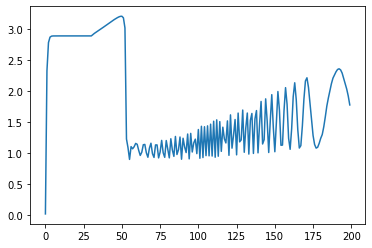

In [128]:
plt.plot(Power_average/1e6)
plt.show()

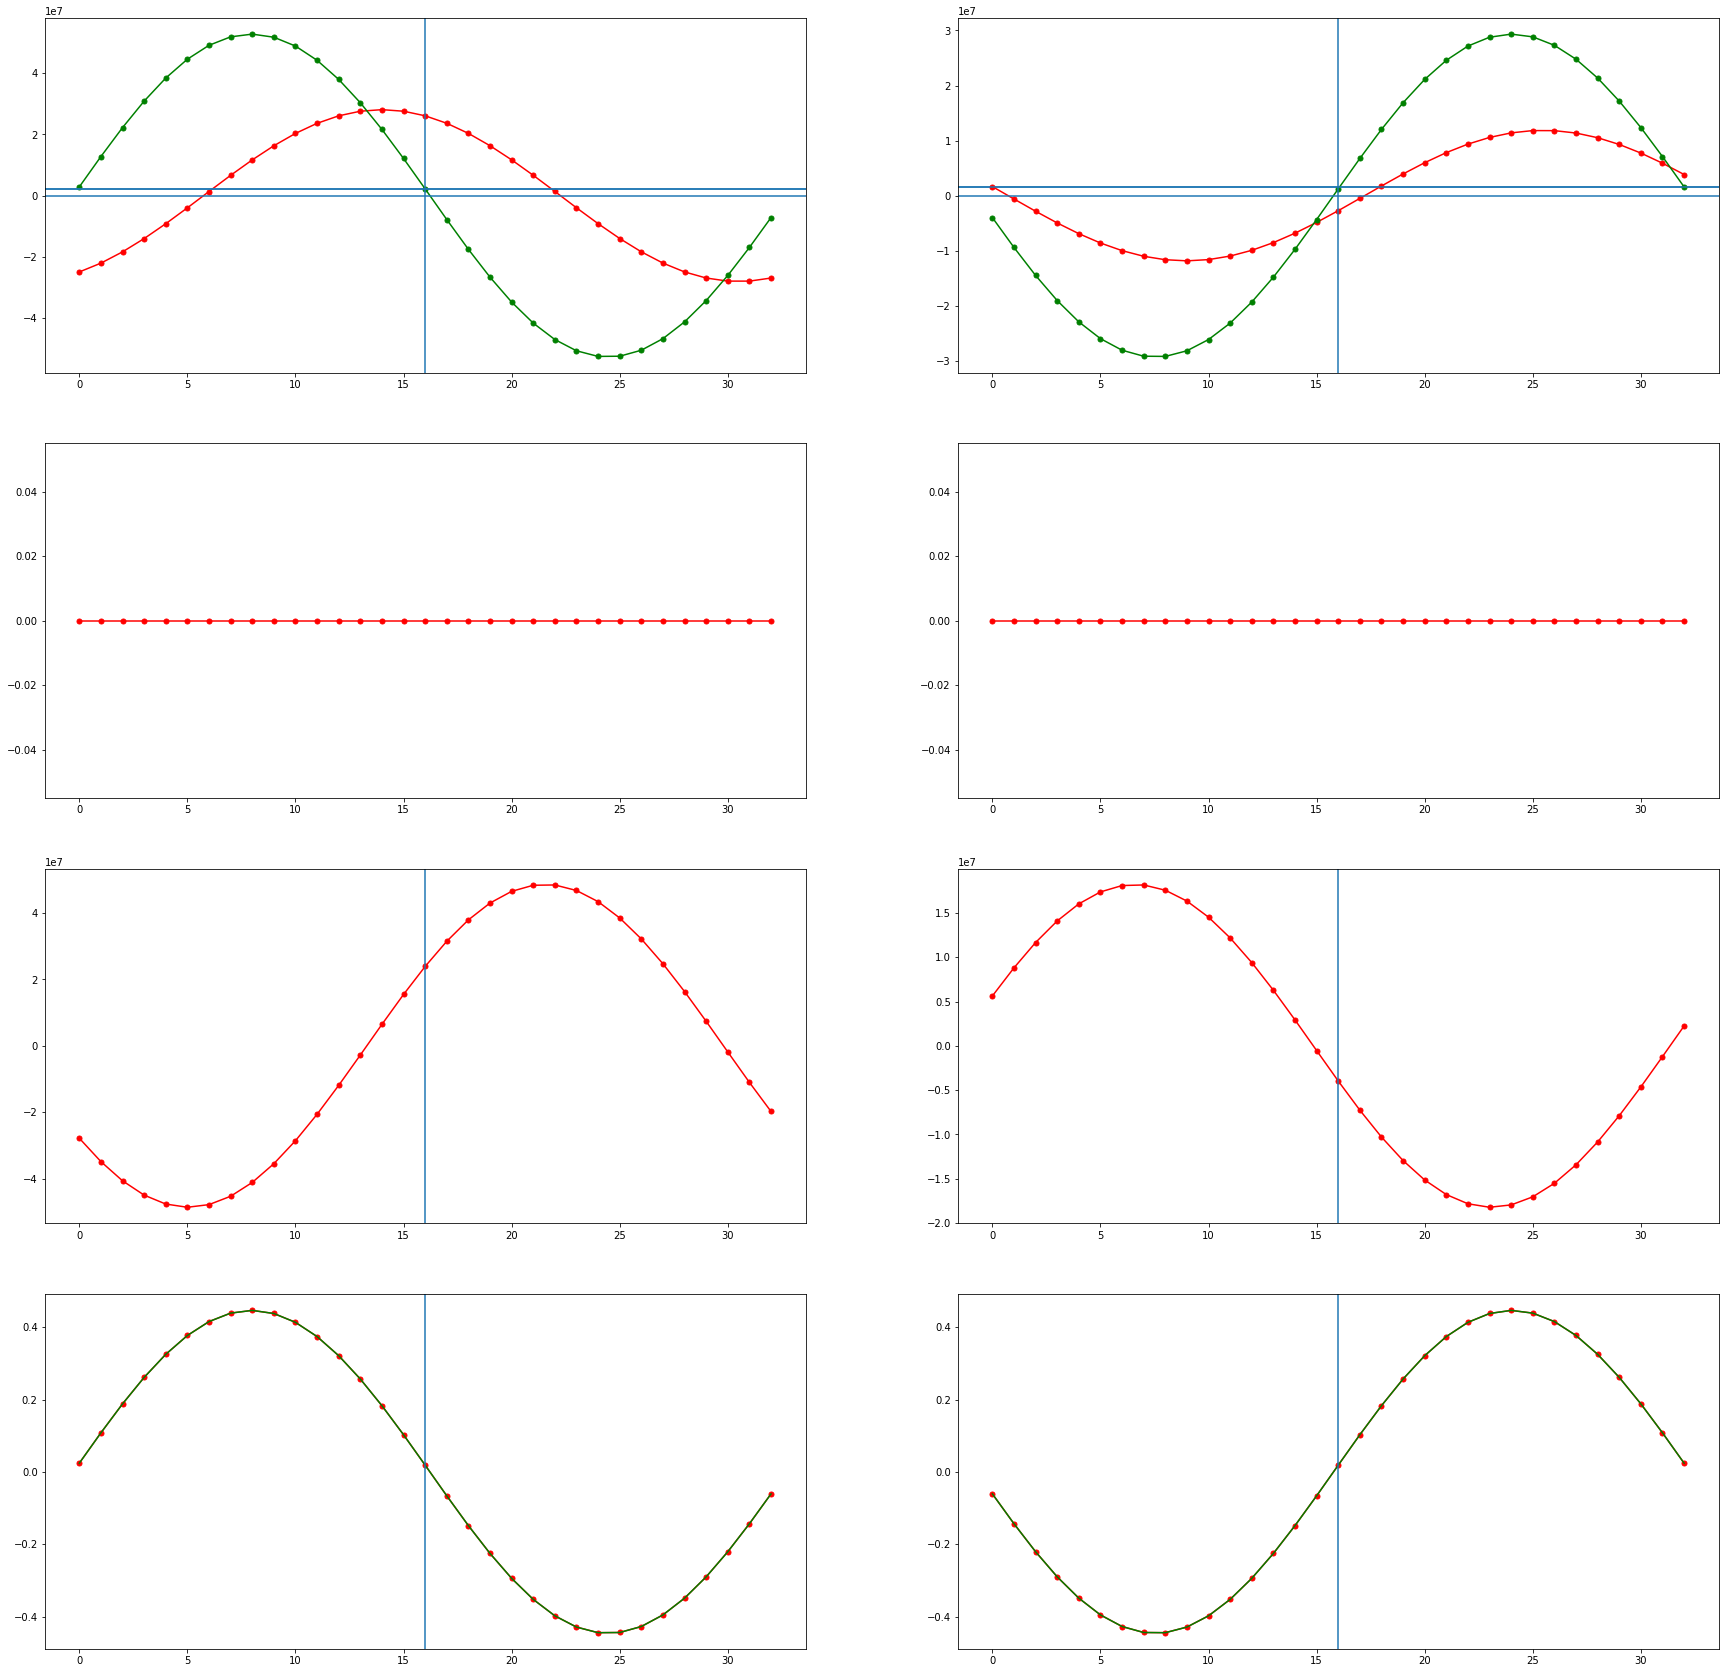

In [129]:
startTurn =int(nTurns/step-1)
startRF = 0 
nRFsamp = 1

rng1 = NpRF*(h[0]*startTurn+startRF)+int(3*NpRF/8)*0
rng2 = NpRF*(h[0]*startTurn+startRF+nRFsamp)-int(3*NpRF/8)*0
step1 = 1
step2 = 1

if nRF>1:
    fig1,axes1 = plt.subplots(4,nRF)
    for i in range(nRF):
        axes1[0][i].plot(V[i][rng1:rng2:step1],'r.-',ms=10)
        axes1[0][i].plot((Vref[i])[rng1:rng2:step1],'g.-',ms=10)
        axes1[0][i].axhline(y=0)
        axes1[0][0].axhline(y=3.7e6/14*8)
        axes1[0][1].axhline(y=3.7e6/14*6)
        #axes1[0][1].axhline(y=7.02e7)
        axes1[0][i].axvline(x=int(NpRF/2))
        axes1[1][i].plot(Ibi[rng1:rng2:step1],'r.-',ms=10)
        if nBeam == 2 :
            axes1[1][i].plot(Ibi2[rng1:rng2:step1],'g.-',ms=10)
        axes1[2][i].plot((V[i]-Vref[i])[rng1:rng2:step1],'r.-',ms=10)
        axes1[2][i].axvline(x=int(NpRF/2))
        axes1[3][i].plot((Ig[i])[rng1:rng2:step1],'r.-',ms=10)
        axes1[3][i].plot((Iref[i])[rng1:rng2:step1],'g-',ms=10)
        #axes1[3][i].plot((Iref[i]-Ig[i])[rng1:rng2:step1],'g-',ms=10)
        axes1[3][i].axvline(x=int(NpRF/2))
        #axes1[0][i].set_ylim([-3e6,3e6])
else:
    fig1,axes1 = plt.subplots(4,1)
    for i in range(nRF):
        axes1[0].plot(V[i][rng1:rng2:step1],'rx-',ms=10)
        axes1[0].plot((Vref[i])[rng1:rng2:step1],'g.-',ms=10)
        axes1[0].axhline(y=0)
        axes1[0].axhline(y=-V0Q[0])
        axes1[0].axhline(y=-V0Q[0])
        axes1[0].axvline(x=int(NpRF/2))
        #axes1[0].set_ylim([3.0e6,4e6])
        axes1[1].plot(Ibi[rng1:rng2:step1],'r.-',ms=10)
        axes1[1].axvline(x=int(NpRF/2))
        axes1[2].plot((V[i]-Vref[i])[rng1:rng2:step1],'r.-',ms=10)
        #axes1[2].set_ylim([-4e6,4e6])
        axes1[3].plot((Ig[i])[rng1:rng2:step1],'r.-',ms=10)
        axes1[3].plot((Iref[i])[rng1:rng2:step1],'g.-',ms=10)
        axes1[3].axhline(y=0)
        axes1[3].axvline(x=int(NpRF/2))
fig1.set_figheight(30)
fig1.set_figwidth(30)

fn_VI = os.path.join(cwd,'VI'+str(startTurn*step)+'.jpg')
plt.savefig(fn_VI,bbox_inches='tight')
plt.show()

In [130]:
datafile = 'f_cav.bin'
datafile = os.path.join(cwd,datafile)
pattern = nRF*'d'
stride = len(pattern)*8
with open(datafile, mode='rb') as file: # b is important -> binary
    fileContent = file.read()
data = np.array([struct.unpack(pattern,fileContent[i*stride:(i+1)*stride]) for i in range(int(len(fileContent)/stride))]).T
frqs = []
for i in range(nRF):
    frqs.append(np.array(data[i])/2/np.pi)
V_max = []
Ig_max = []
for i in range(nRF):
    V_max.append([])
    Ig_max.append([])
    for j in range(int(len(V[i])/NpRF/h[0])-1):
        V_max[i].append(np.max(V[i][j*NpRF*h[0]:(j+1)*NpRF*h[0]]))
        #Ig_max[i].append(np.max(Ig[i][j*NpRF*h[0]:(j+1)*NpRF*h[0]]))

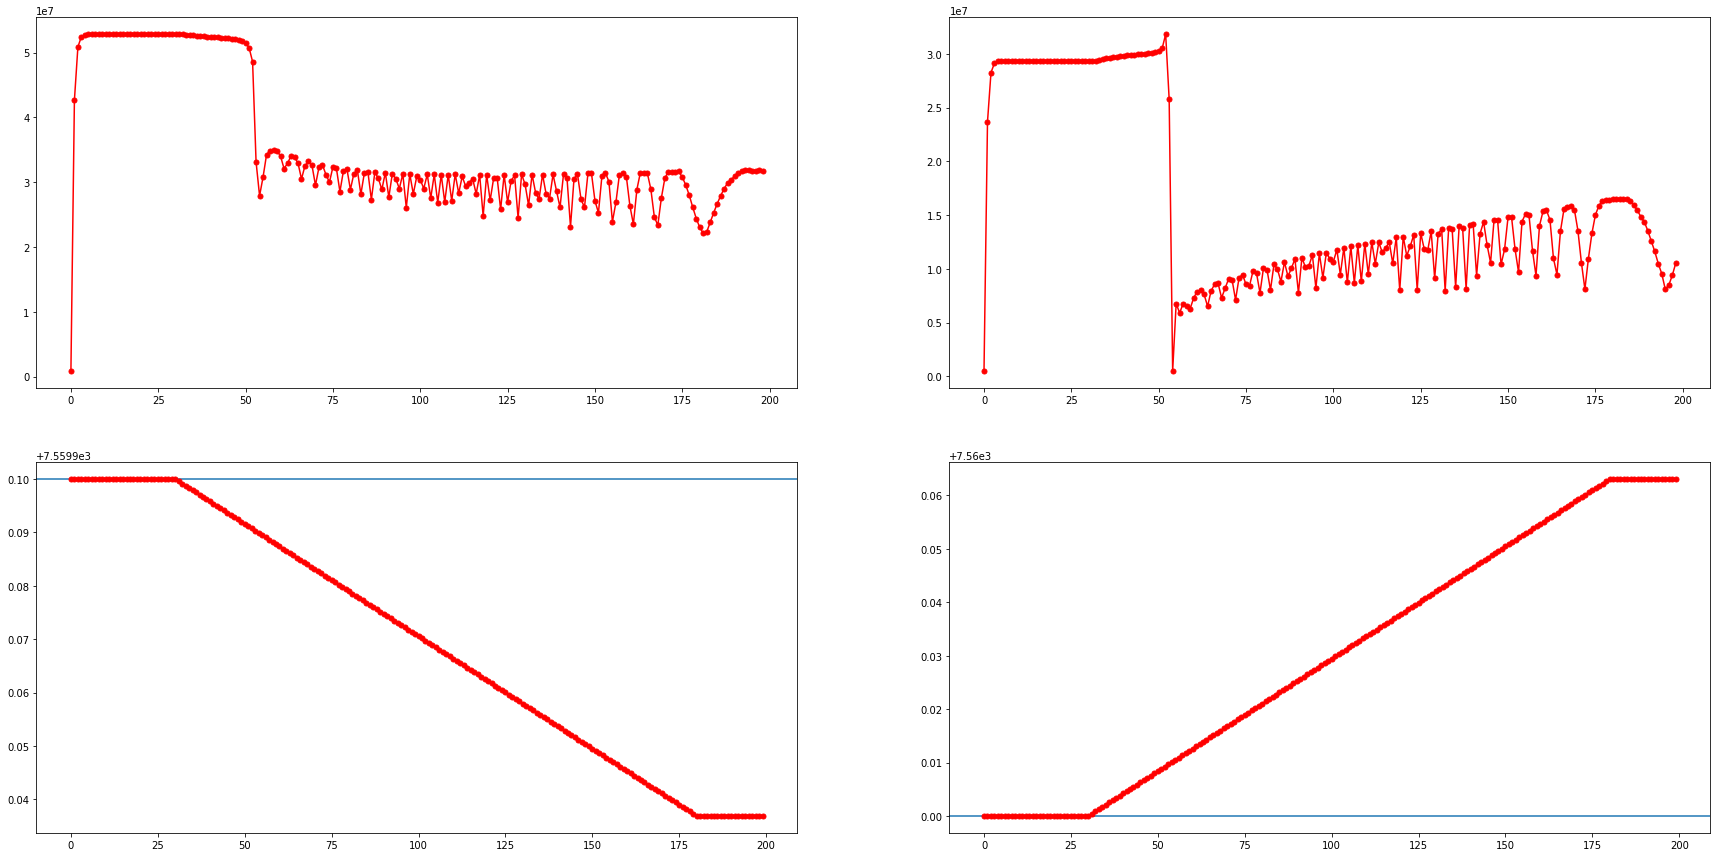

In [131]:
start = 0 # this number times n_per_step gives real turn number 
end = int(nTurns/step)
if nRF>1:
    fig1,axes1 = plt.subplots(2,nRF)
    for i in range(nRF):
        axes1[0][i].plot(V_max[i][start:end],'r.-',ms=10)
        #axes1[0][i].set_yscale('log')
        axes1[1][i].axhline(y = h[i])
        #axes1[1][i].axhline(y = omegarf[i]/(omegarf[0]/h[0])+1)
        #axes1[1][i].axhline(y = omegarf[i]/(omegarf[0]/h[0])-1)
        #axes1[2][i].plot(Ig_max[i][start:end],'r.-',ms=10)
        axes1[1][i].plot(frqs[i][start:end]/(omegarf[0]/h[0]/2/np.pi),'r.-',ms=10)        
else:
    fig1,axes1 = plt.subplots(4,1)
    for i in range(nRF):
        axes1[0].plot(V_max[i][start:end],'r.-',ms=10)
        axes1[1].plot(frqs[i][start:end]/(omegarf[0]/h[0]/2/np.pi),'r.-',ms=10)   
        #axes1[1].axhline(y = omegarf[i]/(omegarf[0]/h[0]))
        
fig1.set_figheight(15)
fig1.set_figwidth(30)

fn_proc = os.path.join(cwd,'process.jpg')
plt.savefig(fn_proc,bbox_inches='tight')
plt.show()

In [132]:
datafilepar = 'init.bin'
datafilepar = os.path.join(cwd,datafilepar)
pat = nTot*'d'
strd = nTot*8
with open(datafilepar, mode='rb') as file: # b is important -> binary
    fileContent = file.read()
datapar = np.array([struct.unpack(pat,fileContent[i*strd:(i+1)*strd]) for i in range(int(len(fileContent)/strd))])
dt_init = np.array(datapar[0])
gamma_init = np.array(datapar[1])

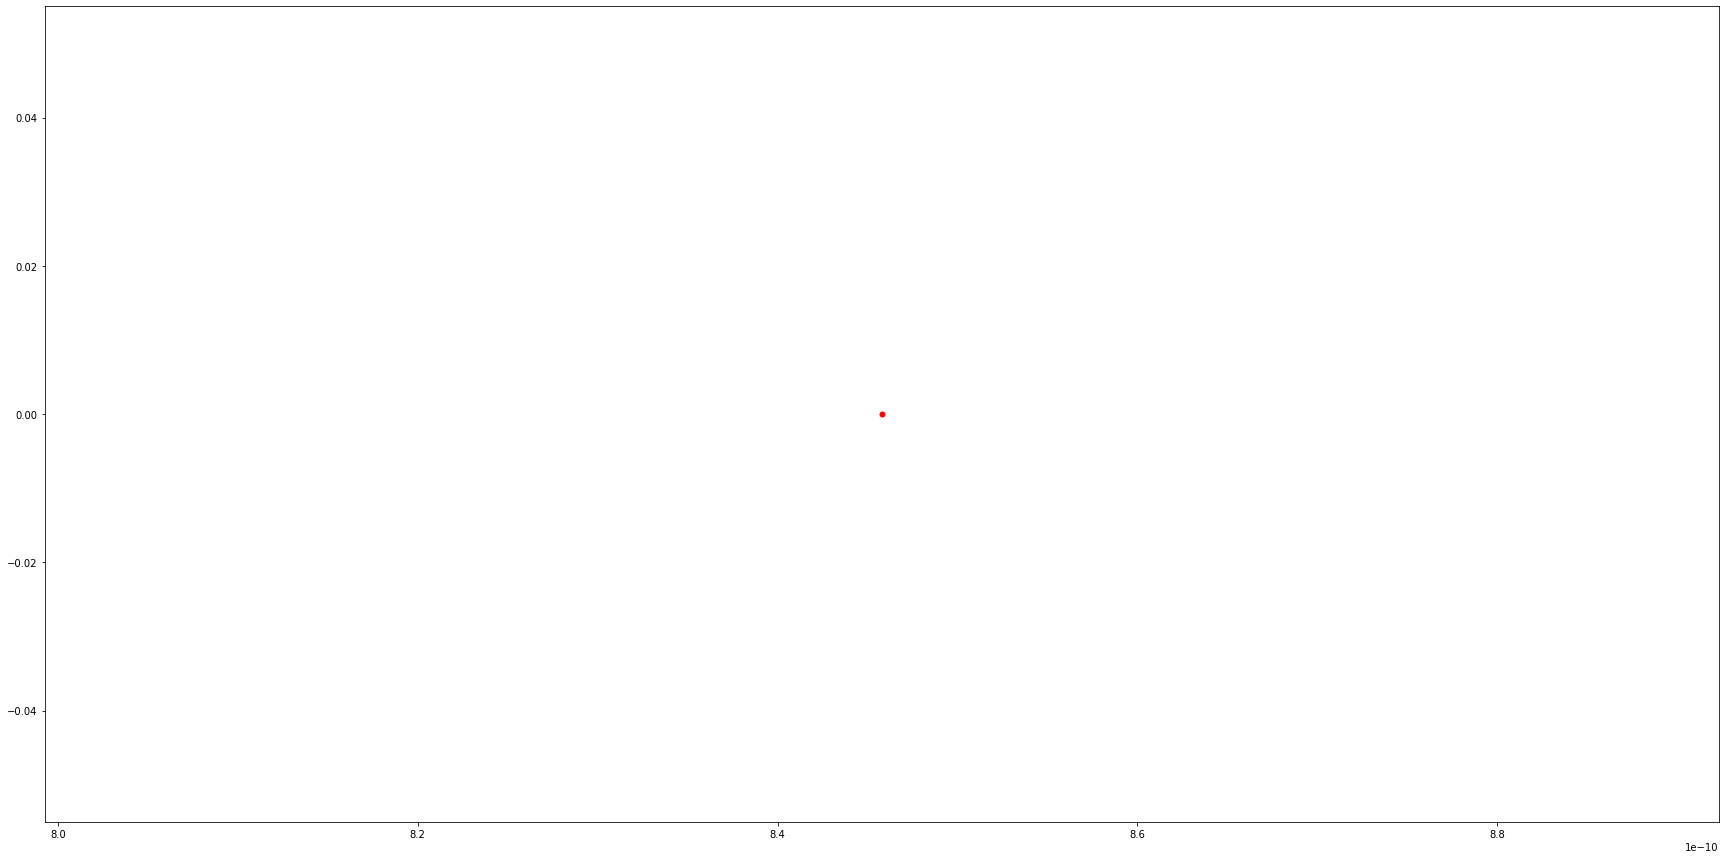

In [133]:
rng1 =  0*nPar
rng2 = int(1*nPar)
step1 = 1

fig1,axes1 = plt.subplots(1,1)

axes1.plot(dt_init[rng1:rng2:step1],gamma_init[rng1:rng2:step1]-Gamma0,'r.',ms=10)

bin_centers = [1*dthat/2+i*dthat for i in range(NpRF)]
#for bins in bin_centers:
#axes1.axvline(x = bin_centers[17])
#axes1.axvline(x = bin_centers[15])
#axes1.axvline(x = bin_centers[32])
#axes1.axvline(x = bin_centers[31])
#axes1.axvline(x = bin_centers[16])
#axes1.axvline(x = bin_centers[16]+7.7e-10)
#axes1.axvline(x = bin_centers[16]-7.7e-10)
#axes1.axhline(y = 107.35+0.05)
#axes1.axhline(y = 107.35-0.05)
#axes1.set_xlim([bin_centers[0],bin_centers[-1]])

fig1.set_figheight(15)
fig1.set_figwidth(30)
plt.show()

In [134]:
dt1 = dt_init[rng1:rng2:step1]
delta1 = gamma_init[rng1:rng2:step1]#*(197*931.5e6) # convert into eV
sig_dt1_sqr = np.sum((dt1-np.sum(dt1)/len(dt1))**2)/len(dt1)
sig_delta1_sqr = np.sum((delta1-np.sum(delta1)/len(delta1))**2)/len(delta1)
sig_dt1_delta1 = np.sum((delta1-np.sum(delta1)/len(delta1))*(dt1-np.sum(dt1)/len(dt1)))/len(delta1)
emittance = np.sqrt(sig_dt1_sqr*sig_delta1_sqr-sig_dt1_delta1**2)*np.pi*(197*931.5e6)
print(sig_dt1_sqr**0.5)
print(sig_delta1_sqr**0.5)
print(emittance*6/197)

0.0
0.0
0.0


In [135]:
datafilepar = 'par.bin'
datafilepar = os.path.join(cwd,datafilepar)
nData = int(nTurns/step)
par_store_tot = nTot*nData
pat = nTot*'d'*2
strd = nTot*8*2
datapar = array('d')

with open(datafilepar, mode='rb') as file: # b is important -> binary
    datapar.fromfile(file,par_store_tot*2)
    
dt = np.zeros(par_store_tot)
gamma = np.zeros(par_store_tot)
for i in range(nData):
    dt[i*nPar*nBunch*nBeam:(i+1)*nPar*nBunch*nBeam] = datapar[i*nBeam*nPar*nBunch*2:(i*2+1)*nPar*nBunch*nBeam]
    gamma[i*nPar*nBunch*nBeam:(i+1)*nPar*nBunch*nBeam] = datapar[(i*2+1)*nBeam*nPar*nBunch:(i*2+2)*nPar*nBunch*nBeam]
    #dt.append(datapar[i*2*nPar*nBunch*2:(i*2+1)*nPar*nBunch*2])
    #gamma.append(datapar[(i*2+1)*nPar*nBunch*2:(i*2+2)*nPar*nBunch*2])

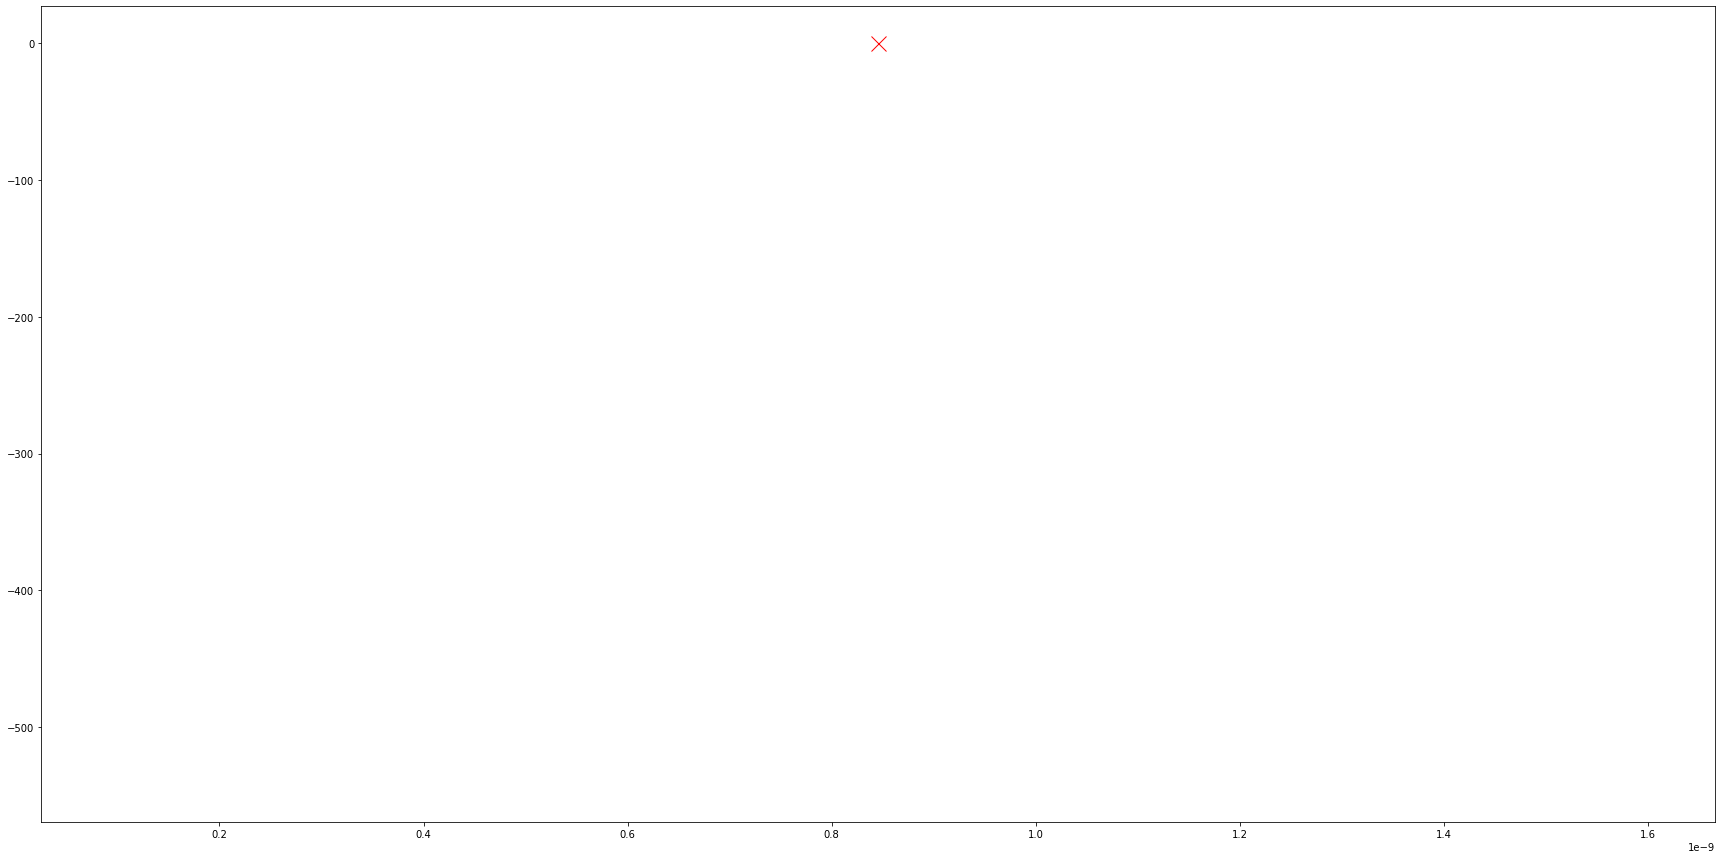

In [136]:
turn_display = 65
bunch_display = 0
nBunch_display = 1
rng11 =  turn_display*nBunch*nBeam*nPar+(bunch_display)*nPar
rng21= turn_display*nBunch*nBeam*nPar+(bunch_display+nBunch_display)*nPar

rng1 = (bunch_display)*nPar
rng2 = (bunch_display+nBunch_display)*nPar
step1 = 1

fig1,axes1 = plt.subplots(1,1)

axes1.plot(dt_init[rng1:rng2:step1],gamma_init[rng1:rng2:step1]-Gamma0,'rx',ms=15)
axes1.plot(dt[rng11:rng21:],gamma[rng11:rng21:]-Gamma0,'g.',ms=15)

bin_centers = [1*dthat/2+i*dthat for i in range(NpRF)]
#for bins in bin_centers:
#axes1.axvline(x = bin_centers[17])
#axes1.axvline(x = bin_centers[15])
#axes1.axvline(x = bin_centers[32])
#axes1.axvline(x = bin_centers[31])
#axes1.axvline(x = bin_centers[32]+3*Trf[0])
#axes1.axvline(x = bin_centers[32]+7.7e-10+3*Trf[0])
#axes1.axvline(x = bin_centers[32]-7.7e-10+3*Trf[0])
#axes1.axhline(y = 107.35+0.05)
#axes1.axhline(y = 107.35-0.05)
#axes1.set_xlim([bin_centers[0]-bunch_display/(f0*h[0])*6,bin_centers[NpRF-1]+bunch_display/(f0*h[0])*6])
axes1.set_xlim([bin_centers[0]+bunch_display*3*Trf[0],bin_centers[NpRF-1]+bunch_display*3*Trf[0]])

fig1.set_figheight(15)
fig1.set_figwidth(30)
plt.show()

In [137]:
def get_bucket_limits(bucket_lower_lim,bucket_upper_lim,beam_shift,Trf,Trev,nParPerData,nParPerTurn,nPar):
    bucket_lower_lim = np.mod(((np.mod(np.mod(bucket_lower_lim,nParPerData),nParPerTurn)/nPar).astype(int)*fill_step+(np.mod(bucket_lower_lim,nParPerData)/nParPerTurn).astype(int)*(beam_shift+0.25))*Trf,Trev)
    bucket_upper_lim = np.mod(((np.mod(np.mod(bucket_upper_lim,nParPerData),nParPerTurn)/nPar).astype(int)*fill_step+(np.mod(bucket_upper_lim,nParPerData)/nParPerTurn).astype(int)*(beam_shift+0.25)+1)*Trf,Trev)
    #bucket_lower_lim = (((bucket_lower_lim%(nParPerData))%(nParPerTurn)/nPar).astype(int)*3+((bucket_lower_lim%(nParPerData))/(nParPerTurn)).astype(int)*(beam_shift+0.5))*Trf
    #bucket_upper_lim = (((bucket_upper_lim%(nParPerData))%(nParPerTurn)/nPar).astype(int)*3+((bucket_upper_lim%(nParPerData))/(nParPerTurn)).astype(int)*(beam_shift+0.5)+1)*Trf
    return bucket_lower_lim,bucket_upper_lim
def get_mask(bucket_lower_lim, bucket_upper_lim,dt,mask):
    mask = np.abs((np.sign((dt-bucket_lower_lim)*(dt-bucket_upper_lim))-1)/2).astype(bool)
    return mask

In [138]:
bucket_lower_lim3 = np.arange(start=0, stop=len(dt))
bucket_upper_lim3 = np.arange(start=0, stop=len(dt))
mask = np.ones(len(dt))

In [139]:
bucket_lower_lim3,bucket_upper_lim3 = get_bucket_limits(bucket_lower_lim3,bucket_upper_lim3,beam_shift,Trf[0],T0,nBeam*nBunch*nPar,nBunch*nPar,nPar)

In [140]:
mask = get_mask(bucket_lower_lim3, bucket_upper_lim3,dt,mask)

Calculate the M1 and M2 for all bunches in all recorded data

In [141]:
dt_mask = dt*mask
gamma_mask = gamma*mask

t_0 = np.zeros(nData*nBeam*nBunch)
gamma_0 = np.zeros(nData*nBeam*nBunch)
nPar_mask = np.zeros(nData*nBeam*nBunch)
sig_t = np.zeros(nData*nBeam*nBunch)
sig_gamma = np.zeros(nData*nBeam*nBunch)
sig_t_gamma = np.zeros(nData*nBeam*nBunch)
emittance = np.zeros(nData*nBeam*nBunch)
    
for i in range(nData*nBeam*nBunch):
    nPar_mask[i] = np.sum(mask[i*nPar:(i+1)*nPar])
for i in range(nData*nBeam*nBunch):
    t_0[i] = np.sum(dt_mask[i*nPar:(i+1)*nPar])/nPar_mask[i]
    gamma_0[i] = (np.sum(gamma_mask[i*nPar:(i+1)*nPar]))/nPar_mask[i]

/home/txin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/home/txin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


In [142]:
for i in range(nData*nBeam*nBunch):
    sig_t[i] = np.sum(((dt_mask[i*nPar:(i+1)*nPar]-t_0[i])*mask[i*nPar:(i+1)*nPar])**2)/nPar_mask[i]
    sig_gamma[i] = np.sum(((gamma_mask[i*nPar:(i+1)*nPar]-gamma_0[i])*mask[i*nPar:(i+1)*nPar])**2)/nPar_mask[i]
    sig_t_gamma[i] = np.sum((dt_mask[i*nPar:(i+1)*nPar]-t_0[i])*(gamma_mask[i*nPar:(i+1)*nPar]-gamma_0[i])*mask[i*nPar:(i+1)*nPar])/nPar_mask[i]
    emittance[i] = np.sqrt(sig_t[i]*sig_gamma[i]-sig_t_gamma[i]**2)*np.pi*(197*931.5e6)*6/197

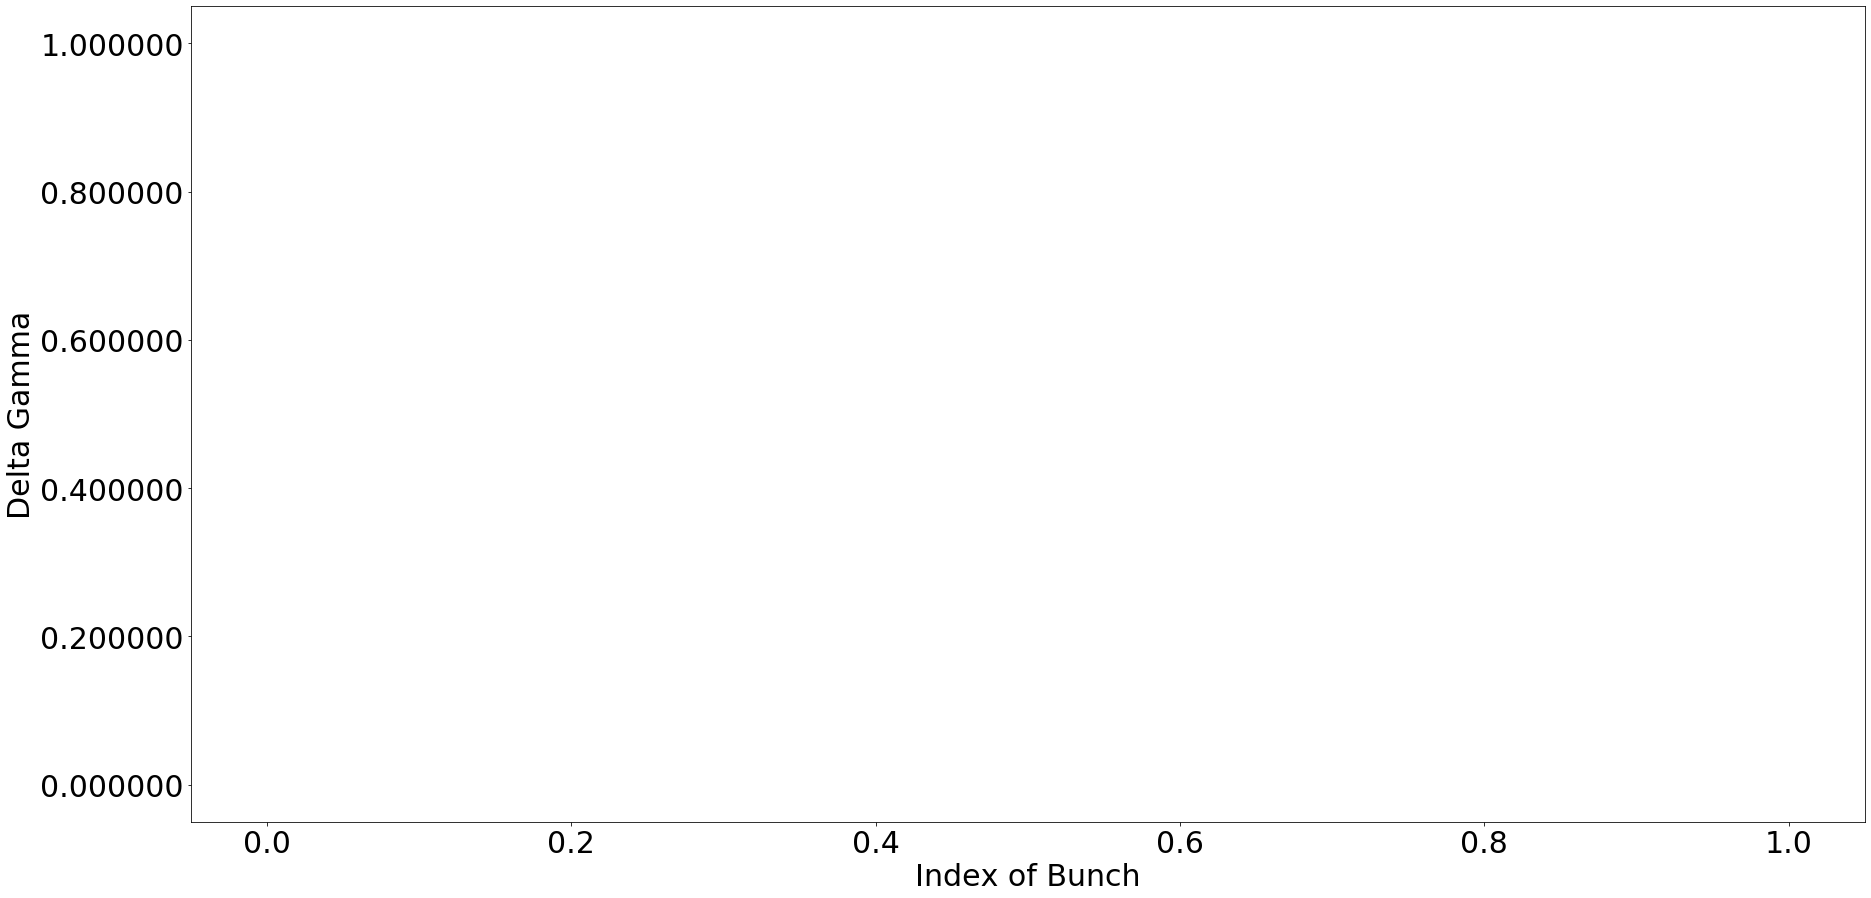

In [151]:
# plot average gamma along the train.
turn_display = 150#int(nTurns/step-1)
bunch_display = 0
rng1 =  turn_display*nBeam*nBunch
rng2= rng1+nBunch*1

fig1,axes1 = plt.subplots(1,1)

axes1.plot(gamma_0[rng1:rng2:]-Gamma0,'r.-',ms=15)

axes1.set_xlabel('Index of Bunch',fontsize=30)
axes1.set_ylabel('Delta Gamma',fontsize=30)
axes1.tick_params(labelsize=30)
y_labels = axes1.get_yticks()
axes1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.6f'))

fig1.set_figheight(15)
fig1.set_figwidth(30)
fn_train = os.path.join(cwd,'train.jpg')
plt.savefig(fn_train,bbox_inches='tight')
plt.show()

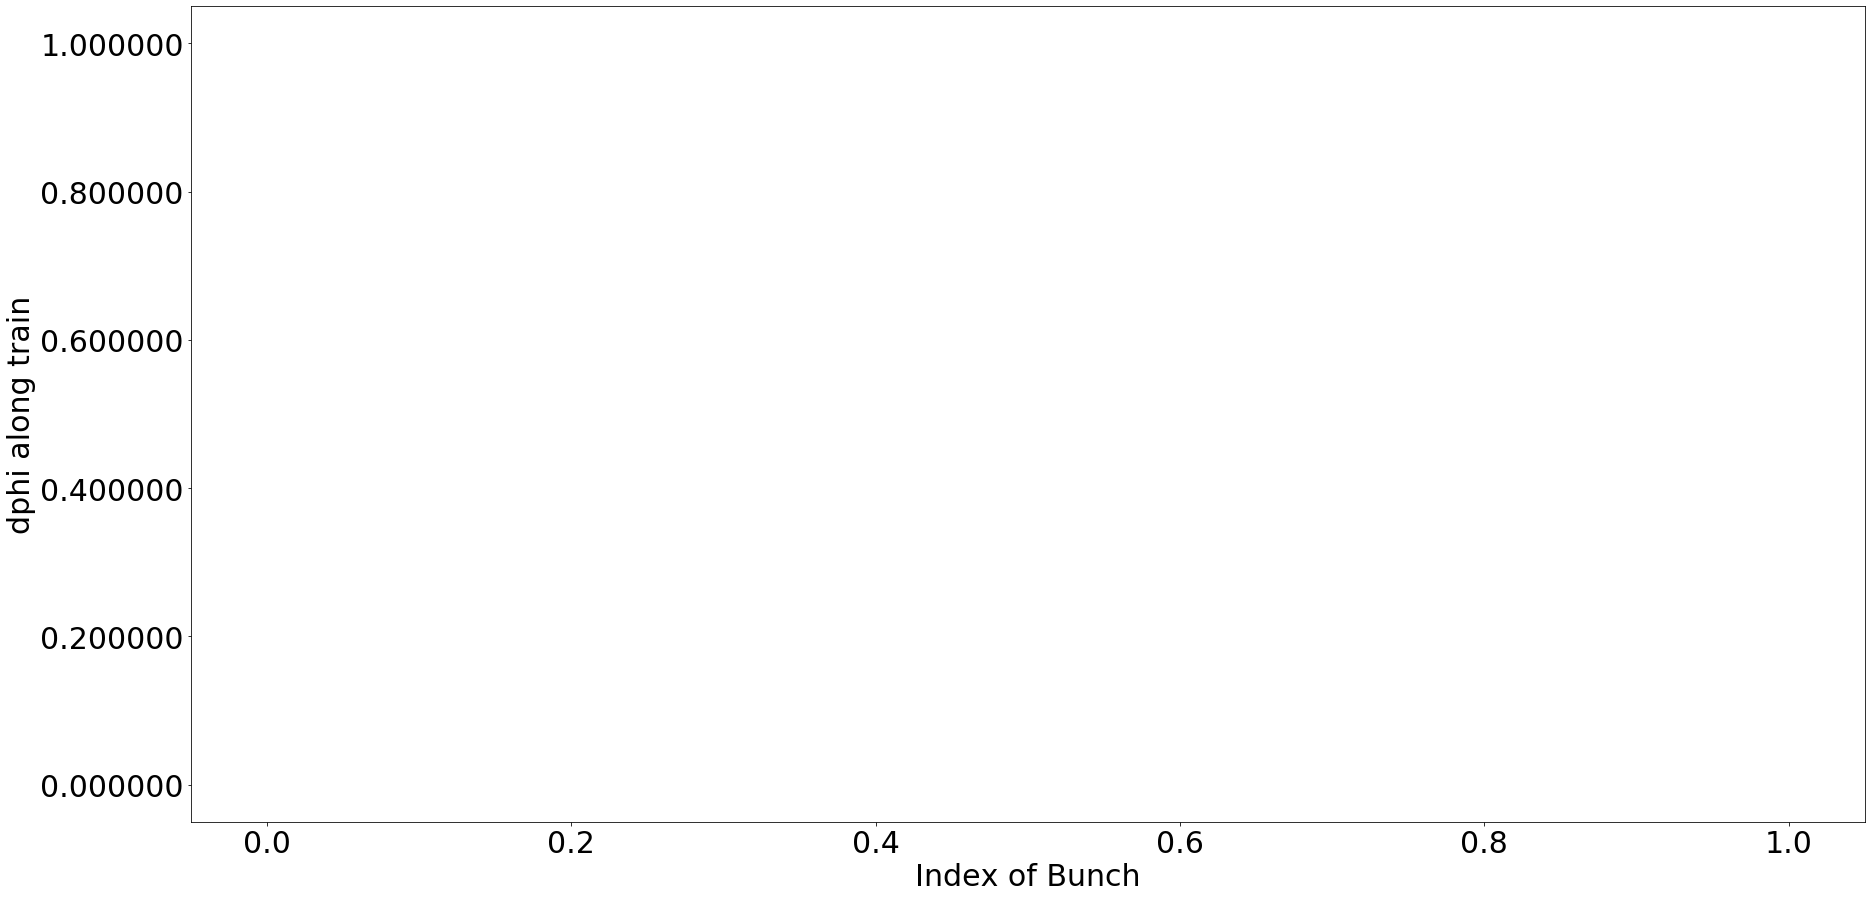

In [169]:
# plot average arriving time of the centroid along the train.
turn_display = 53#int(nTurns/step-1)
bunch_display = 0
rng1 =  turn_display*nBeam*nBunch
rng2= rng1+nBunch*1
centroids = [(i*fill_step+0.5)*Trf[mainRF] for i in range(nBunch)]
fig1,axes1 = plt.subplots(1,1)

axes1.plot((t_0[rng1:rng2:]-centroids)/Trf[0]*360,'r.-',ms=15)

axes1.set_xlabel('Index of Bunch',fontsize=30)
axes1.set_ylabel('dphi along train',fontsize=30)
axes1.tick_params(labelsize=30)
y_labels = axes1.get_yticks()
axes1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.6f'))

fig1.set_figheight(15)
fig1.set_figwidth(30)
fn_train = os.path.join(cwd,'train.jpg')
plt.savefig(fn_train,bbox_inches='tight')
plt.show()

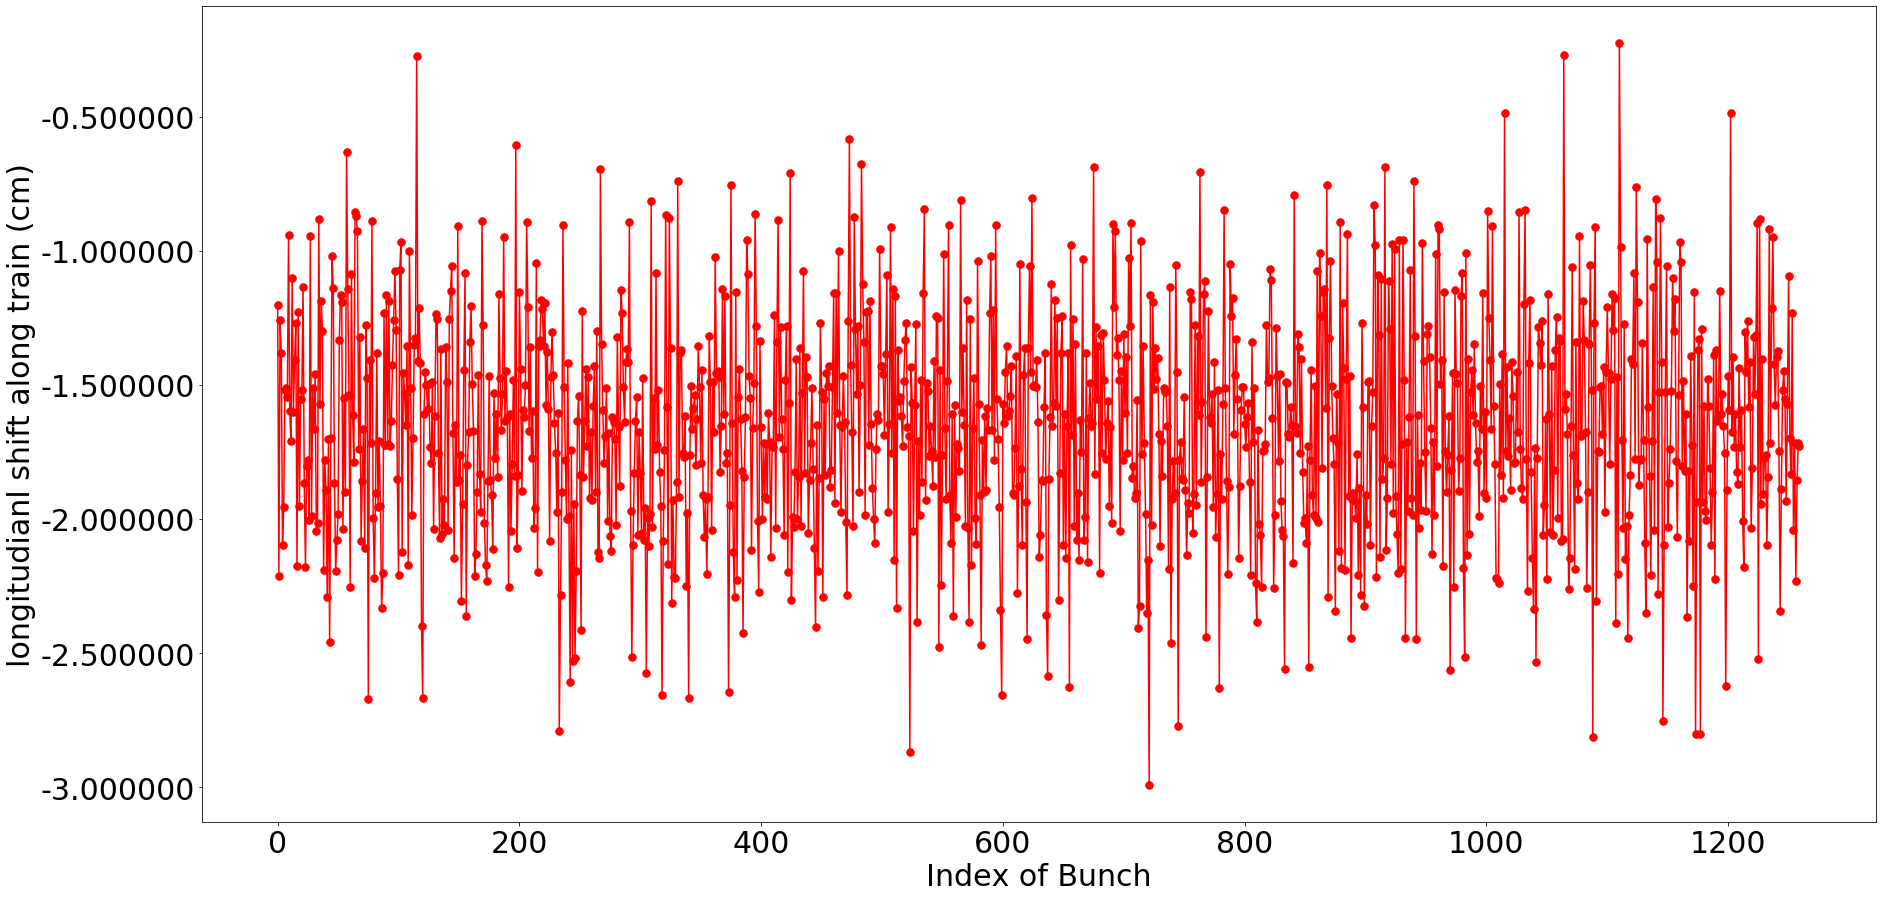

In [167]:
# plot average distance shift of the centroid along the train.
turn_display = 52#int(nTurns/step-1)
bunch_display = 0
rng1 =  turn_display*nBeam*nBunch
rng2= rng1+nBunch*1
centroids = [(i*fill_step+0.5)*Trf[mainRF] for i in range(nBunch)]
fig1,axes1 = plt.subplots(1,1)

axes1.plot((t_0[rng1:rng2:]-centroids)*clight*100,'r.-',ms=15)

axes1.set_xlabel('Index of Bunch',fontsize=30)
axes1.set_ylabel('longitudianl shift along train (cm)',fontsize=30)
axes1.tick_params(labelsize=30)
y_labels = axes1.get_yticks()
axes1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.6f'))

fig1.set_figheight(15)
fig1.set_figwidth(30)
fn_train = os.path.join(cwd,'train_dist.jpg')
plt.savefig(fn_train,bbox_inches='tight')
plt.show()

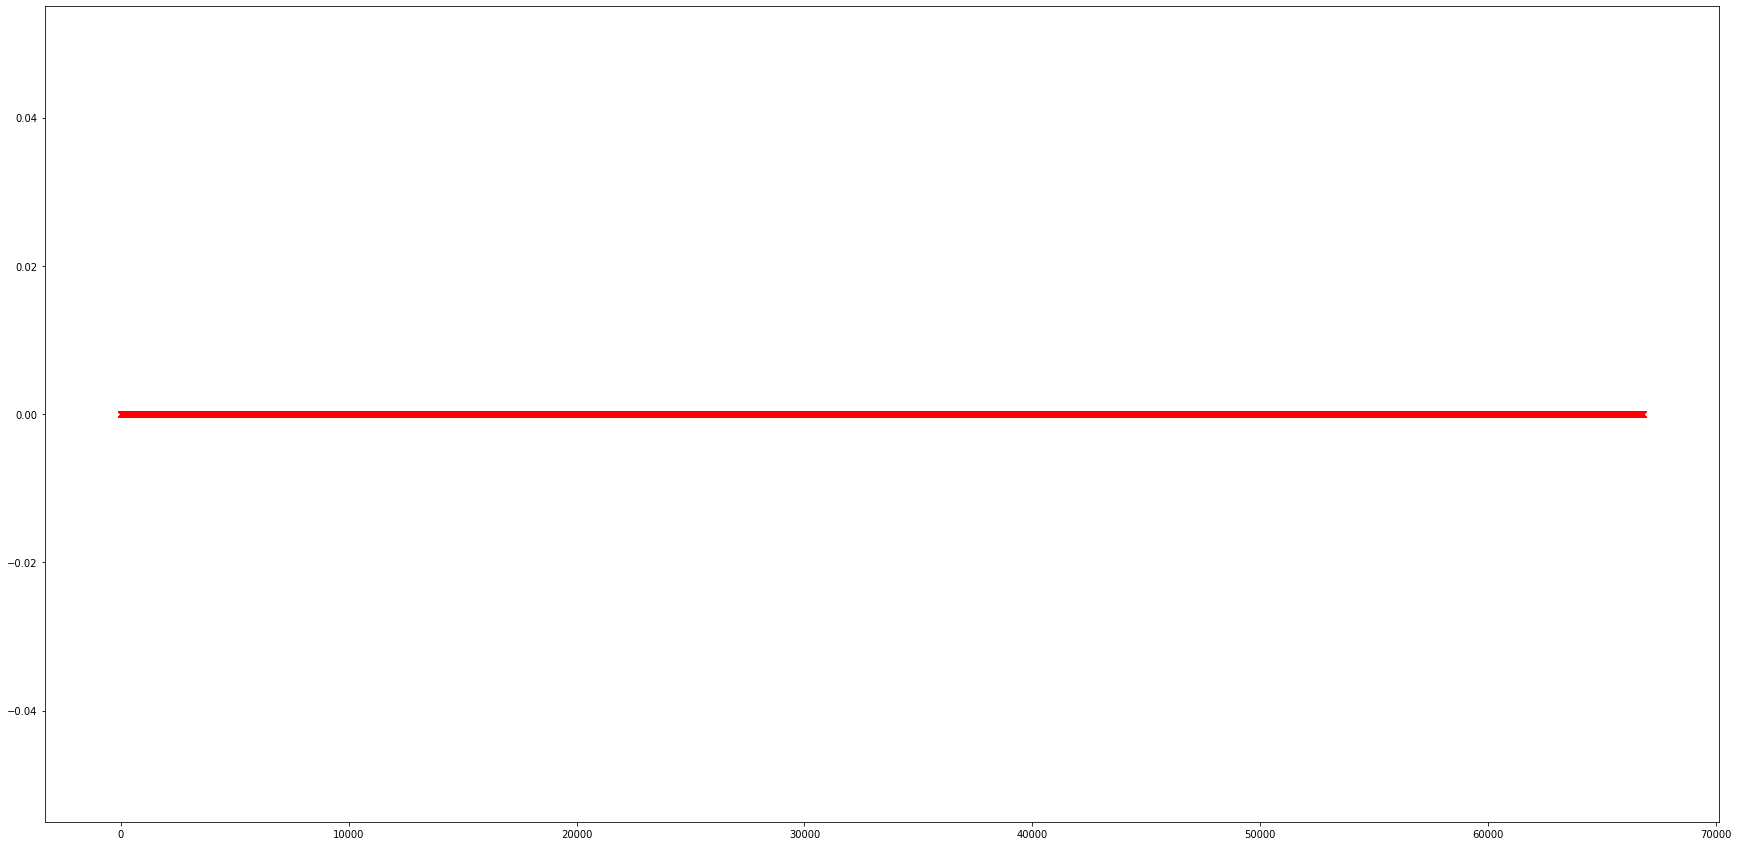

In [146]:
# emittance plot
turn_display = 0
bunch_display = 0
rng1 =  turn_display*nBeam*nBunch
rng2= rng1+nBunch*200

fig1,axes1 = plt.subplots(1,1)
fig1.set_figheight(15)
fig1.set_figwidth(30)

axes1.plot(emittance[rng1:rng2:],'rx-')
fn_emittance = os.path.join(cwd,'Emittance.jpg')
plt.savefig(fn_emittance,bbox_inches='tight')
plt.show()

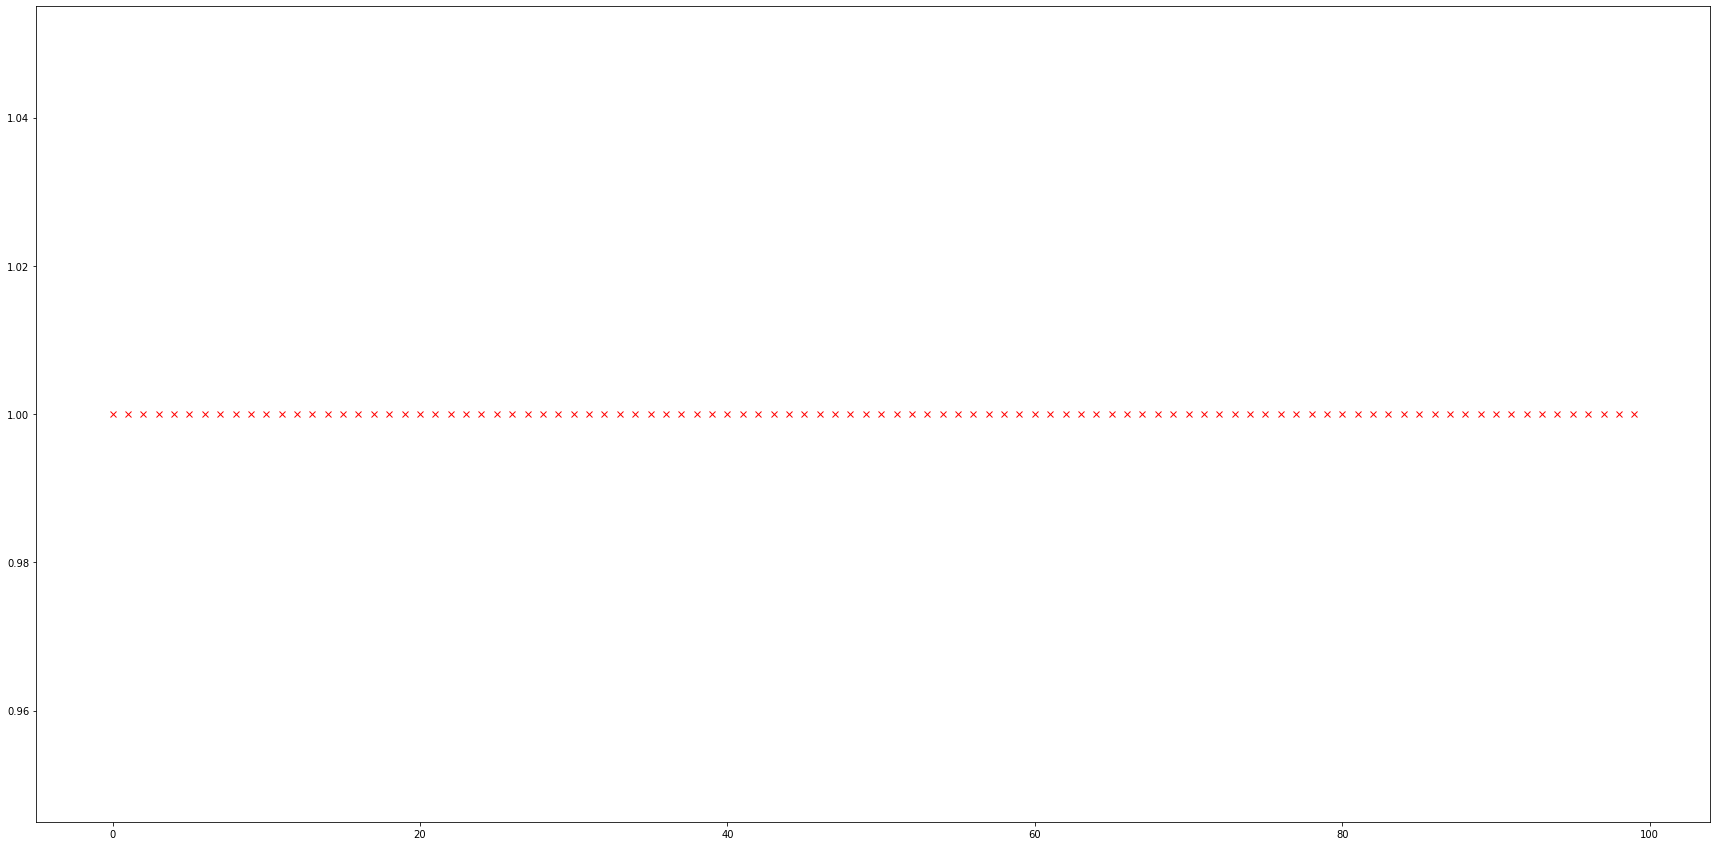

In [72]:
# particle loss
turn_display = 0
bunch_display = 0
rng1 =  turn_display*nBeam*nBunch
rng2= rng1+100#nBunch*1

fig1,axes1 = plt.subplots(1,1)
fig1.set_figheight(15)
fig1.set_figwidth(30)
bin_centers = [1*dthat/2+i*dthat for i in range(NpRF)]

axes1.plot(nPar_mask[rng1:rng2:],'rx')
plt.show()

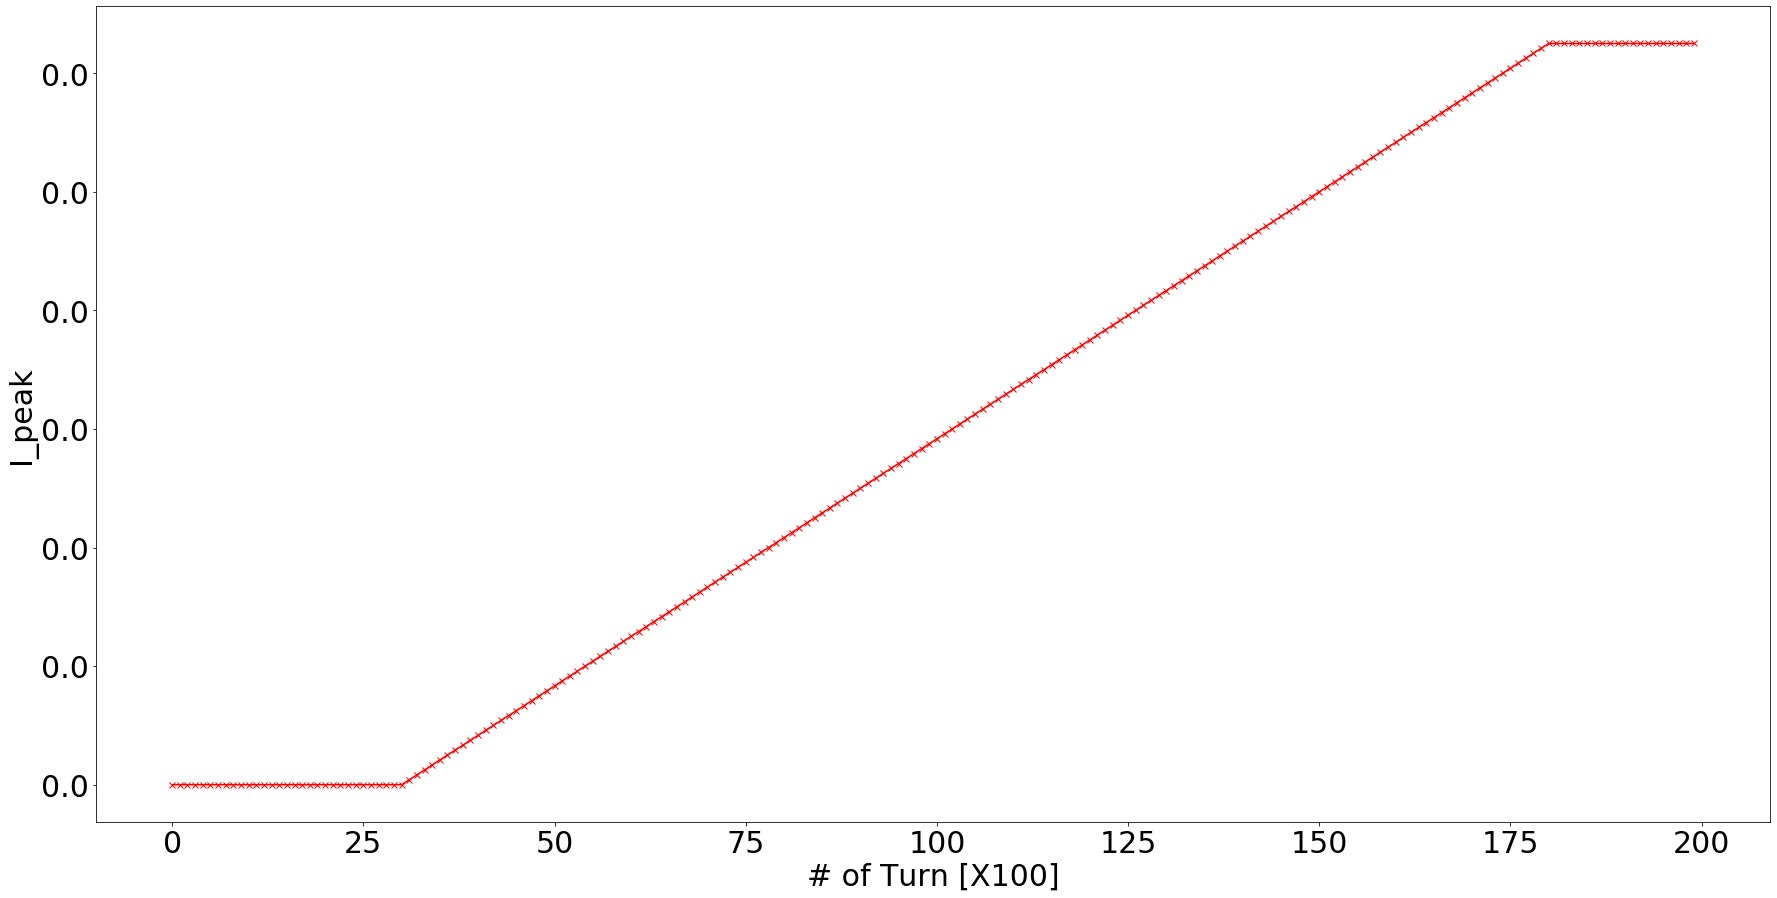

In [73]:
# I peak
I_peak = np.zeros(nData)
for i in range(nData):
    I_peak[i] = np.max(Ibi[i*NpRF*h[0]:(i+1)*NpRF*h[0]])

fig1,axes1 = plt.subplots(1,1)
axes1.plot(I_peak,'rx-')

fig1.set_figheight(15)
fig1.set_figwidth(30)

axes1.set_xlabel('# of Turn [X'+str(step)+']',fontsize=30)
axes1.set_ylabel('I_peak',fontsize=30)
axes1.tick_params(labelsize=30)
y_labels = axes1.get_yticks()
axes1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))
fn_Ipeak = os.path.join(cwd,'Ipeak.jpg')
plt.savefig(fn_Ipeak,bbox_inches='tight')
plt.show()

In [152]:
datafilepar = 'first.bin'
datafilepar = os.path.join(cwd,datafilepar)
with open(datafilepar, mode='rb') as file: # b is important -> binary
    fileContent = file.read()
datapar = np.array([struct.unpack('dd',fileContent[i*16:(i+1)*16]) for i in range(int(len(fileContent)/16))]).T
first_dt = np.array(datapar[0])
first_gamma = np.array(datapar[1])

In [153]:
def Zparallel(Rsh, QL, omega0, omega):
    return Rsh/(1+1j*QL*(omega/omega0-omega0/omega))

In [154]:
#r0 = (79*1.6e-19)**2/(197*1.7e-27*3e8*3e8) # gold
#r0 = (1*1.6e-19)**2/(1*1.7e-27*3e8*3e8) # Proton
r0 = (1*1.6e-19)**2/(1*9.10938356e-31*3e8*3e8)

pmax = nBunch # number of samples 
mu = 1#h[mainRF]%nBunch # 

ps = np.array([float(i) for i in range(-pmax,pmax)])
ps[pmax]=1e-16 # get rid of the zero point to avoid 1/0 problem in python

# for the calculation of real part of Omega
p_M_omega0 = ps*nBunch*2*np.pi*f0
Zs0 = np.array([Zparallel(R[i],QL[i],omegac[i],p_M_omega0) for i in range(nRF)])
factor1 = nBunch*NperBunch*r0*eta/(2*Gamma0*T0**2*Qs*f0*2*np.pi)
delta_omegas = factor1*np.sum(p_M_omega0*np.imag(Zs0))
omegas = Qs*2*pi*f0+delta_omegas

omegas1 = ((ps*nBunch+mu)*2*np.pi*f0+omegas)
Zs1 = np.array([Zparallel(R[i],QL[i],omegac[i],omegas1) for i in range(nRF)])
factor1 = nBunch*NperBunch*r0*eta/(2*Gamma0*T0**2*omegas)
deltaOmegaRe = factor1*np.sum(omegas1*np.imag(Zs1))

# for the calculation of the imaginary part of Omega
omegas2 = ((ps*nBunch+mu)*2*np.pi*f0+(omegas))

factor2 = nBunch*NperBunch*r0*eta/(2*Gamma0*T0**2*(omegas))

Zs2 = np.array([Zparallel(R[i],QL[i],omegarf[i],omegas2) for i in range(nRF)])
deltaOmegaIm = factor2*np.sum(omegas2*np.real(Zs2))
print(deltaOmegaRe)
print(deltaOmegaIm)

-824.7246692085166
0.0016681198765141094


In [155]:
omegac/2/pi-omegarf/2/pi

array([-4933.04216146,  4933.04216146])

[1.         0.00333624 1.        ]
[[ 6.47800489e+14 -2.16077693e+12 -6.47800492e+14]
 [-2.16077693e+12  7.20743938e+09  2.16077694e+12]
 [-6.47800492e+14  2.16077694e+12  6.47800494e+14]]
Fitted Tau =  299.7386501151019
TauAnalytical =  599.4773002104096
TauSimplified  =  4.0572619562628315e-06
Fitted Tau     =  299.7386501151019
Tau_including_artificial_Damping_Term =  -0.0015745303145170981
eta =  0.001040580123244694
Qs =  0.08122018505092511
f0 =  78196.2883627698
fs =  6351.117011119665


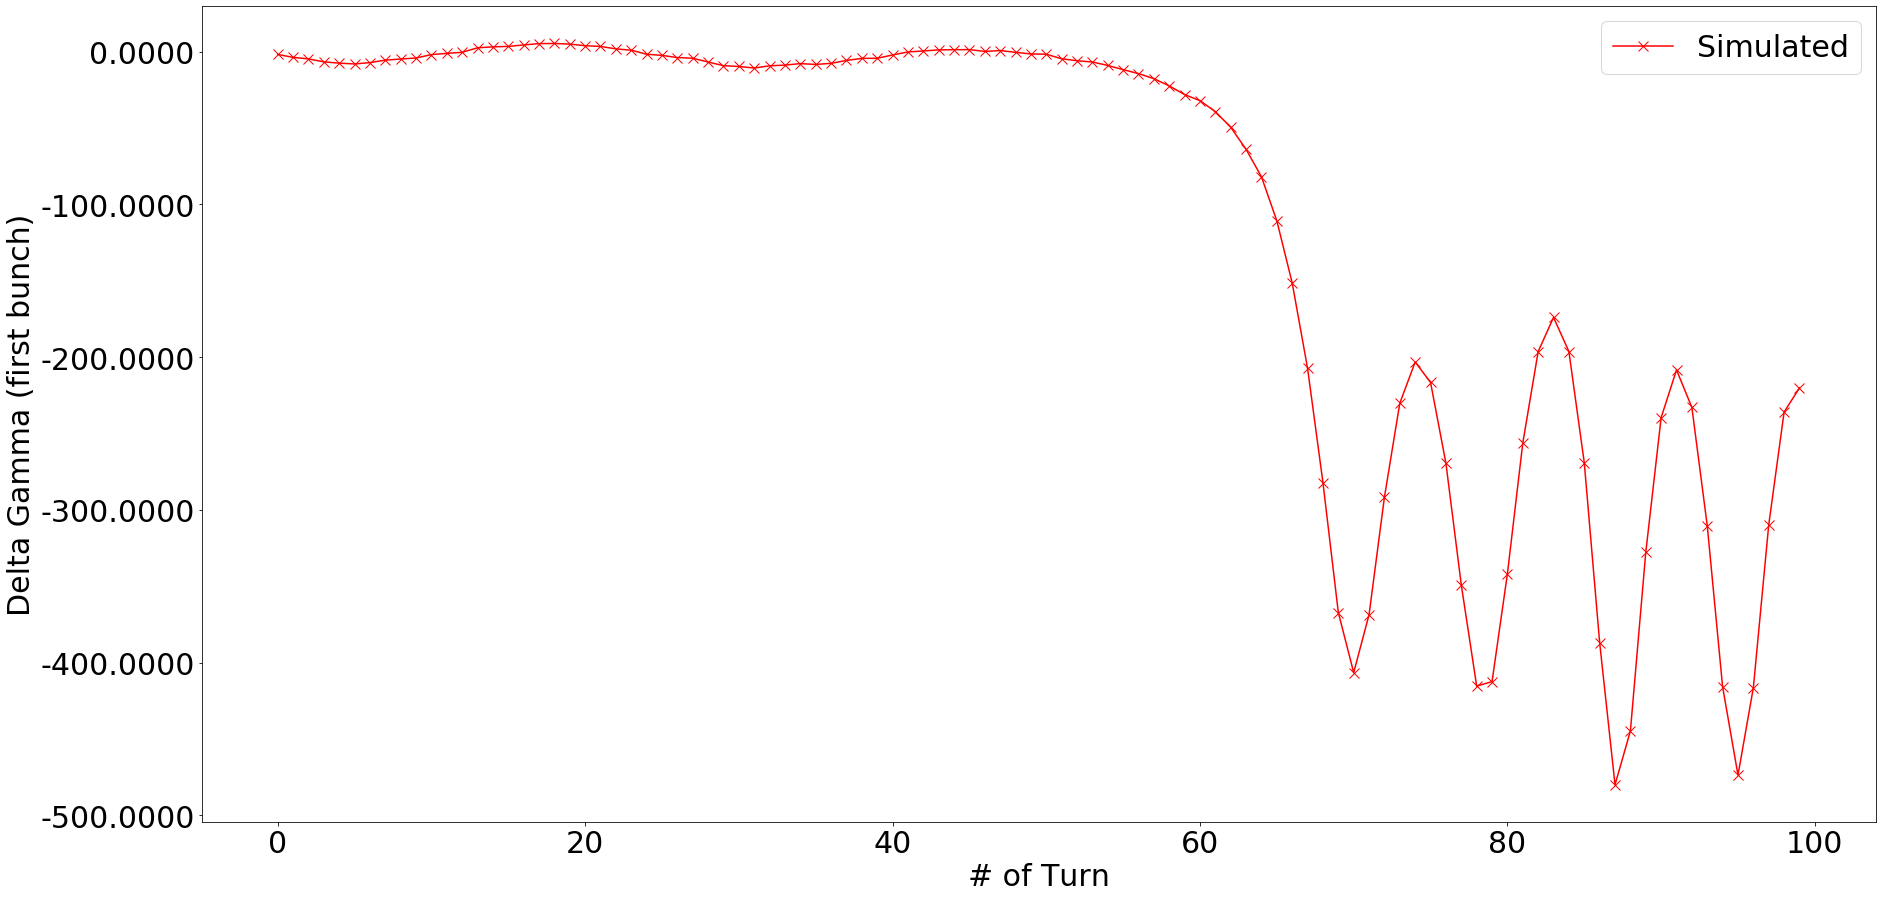

In [164]:
# Fitted
def func_exp_fit(x, a, b, c):
    return a*np.exp(b*x)+c
if 1:
    startTurn = 0
    endTurn = 1000
    delta_gamma_env = np.zeros(int((endTurn-startTurn)*Qs))
    TTurns = int(1/Qs) # numbers of turns per synchrotron oscillation
    delta_gamma_turn = np.array([i*TTurns+startTurn for i in range(len(delta_gamma_env))])
    delta_gamma_time = delta_gamma_turn*T0
    for i in range(len(delta_gamma_env)):
        delta_gamma_env[i] = np.max(first_gamma[i*TTurns+startTurn:(i+1)*TTurns+startTurn])-Gamma0
    popt, pcov = curve_fit(func_exp_fit, delta_gamma_time, \
                           delta_gamma_env,bounds=([-1e-1,0,-1e-1], [1, deltaOmegaIm*2, 1]),\
                           maxfev=2000000)
    print(popt)
    print(pcov)

    print("Fitted Tau = ",1/popt[1])
    delta_gamma_fitted = popt[0]*np.exp(popt[1]*delta_gamma_time)+popt[2]
    # Analytical
    print("TauAnalytical = ",1/deltaOmegaIm)
    TauInver = nBunch*NperBunch*r0*eta/(2*Gamma0*T0**2*Qs*f0*2*np.pi)*(h[mainRF]*2*np.pi*f0+f0*Qs*2*np.pi)*R[mainRF]
    print("TauSimplified  = ",1/TauInver)
    TauInver = deltaOmegaIm
    print("Fitted Tau     = ",1/popt[1])
    TauInver = (deltaOmegaIm-Qs/Ek_damp/2/T0)
    print("Tau_including_artificial_Damping_Term = ",1/TauInver)

    temp_time = np.array([i*T0 for i in range(len(first_gamma))])

    analy = popt[0]*np.exp(TauInver*delta_gamma_time)+popt[2]
rng1 =  2200
rng2 = 2300#int(nTurns-1)

step1 = 1

fig1,axes1 = plt.subplots(1,1)

axes1.plot(first_gamma[rng1:rng2:step1]-Gamma0,'rx-',ms=10)
#axes1.plot(delta_gamma_turn[rng1:int(rng2/TTurns):step1],delta_gamma_env[rng1:int(rng2/TTurns):step1],'g.-',ms=5)
#axes1.plot(delta_gamma_turn[rng1:int(rng2/TTurns):step1],delta_gamma_fitted[rng1:int(rng2/TTurns):step1],'b.-',ms=20)
#axes1.plot(delta_gamma_turn[rng1:int(rng2/TTurns):step1],analy[rng1:int(rng2/TTurns):step1],'y.-',ms=30)
#axes1.set_yscale('log')

#axes1.plot(first_dt[rng1:rng2:step1],first_gamma[rng1:rng2:step1]-Gamma0,'r.-',ms=10)

#axes1.plot(first_gamma[rng1:rng1+10:step1]-Gamma0,'g.-',ms=30)
#axes1.plot(first_dt[rng1:rng1+10:step1],first_gamma[rng1:rng1+10:step1]-Gamma0,'g.-',ms=30)

#axes1.plot(first_gamma[rng2-1000:rng2:step1]-Gamma0,'b.-',ms=30)

axes1.set_xlabel('# of Turn',fontsize=30)
axes1.set_ylabel('Delta Gamma (first bunch)',fontsize=30)
axes1.tick_params(labelsize=30)
y_labels = axes1.get_yticks()
axes1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.4f'))

axes1.legend(['Simulated','Envelope',f'Fitted,        Growth time = {(1/popt[1]):{1}.{6}} [s]','Analytical,  Growth time = '+f"{1/TauInver:{1}.{6}}"+' [s]'],fontsize=30)
#axes1.axhline(y=bucket_height)
#axes1.axhline(y=-bucket_height)

fig1.set_figheight(15)
fig1.set_figwidth(30)
fn_Bench = os.path.join(cwd,'Bench.jpg')
plt.savefig(fn_Bench,bbox_inches='tight')
print('eta = ',eta)
print('Qs = ',Qs)
print('f0 = ',f0)
print('fs = ',Qs*f0)

plt.show()

6351.117011119665
0.08122018505092511


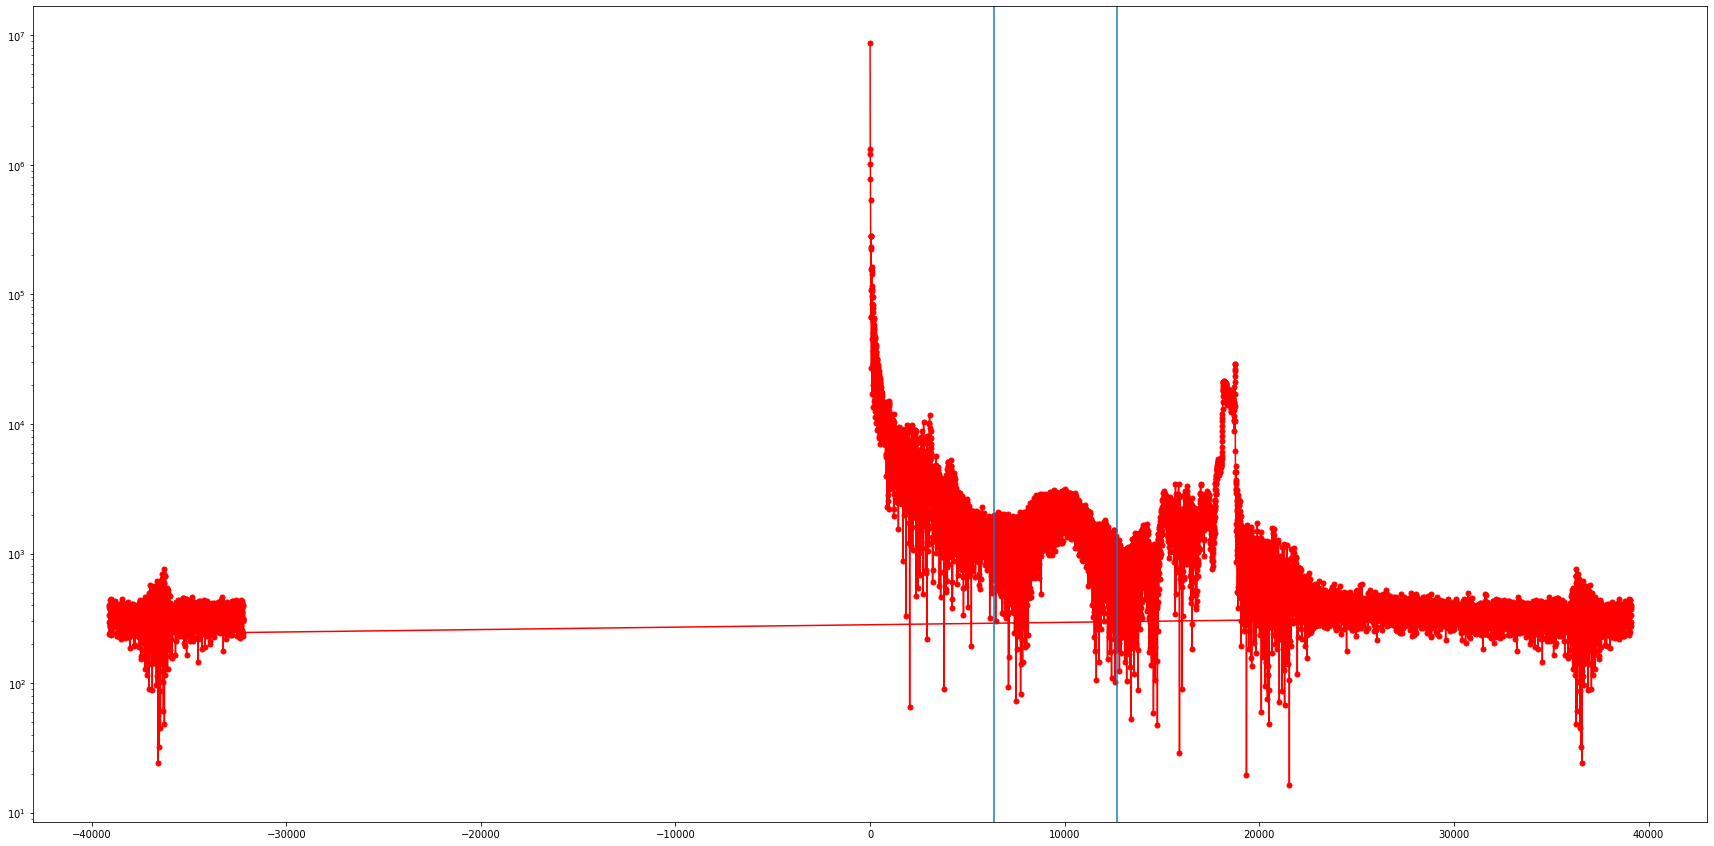

In [157]:
gamma_fft = np.fft.fft(first_gamma-Gamma0)
w = np.fft.fftfreq(len(first_gamma),d=1/f0)
rng1 =  0
rng2 = int(10000)
step1 = 1

fig1,axes1 = plt.subplots(1,1)
axes1.plot(w[rng1:rng2],np.abs(gamma_fft[rng1:rng2]),'r.-',ms=10)
axes1.set_yscale('log')
axes1.axvline(x=Qs*f0)
axes1.axvline(x=2*Qs*f0)

fig1.set_figheight(15)
fig1.set_figwidth(30)
print(Qs*f0)
print(Qs)
plt.show()

In [80]:
(n_fill+n_q_ramp)/step

150.1

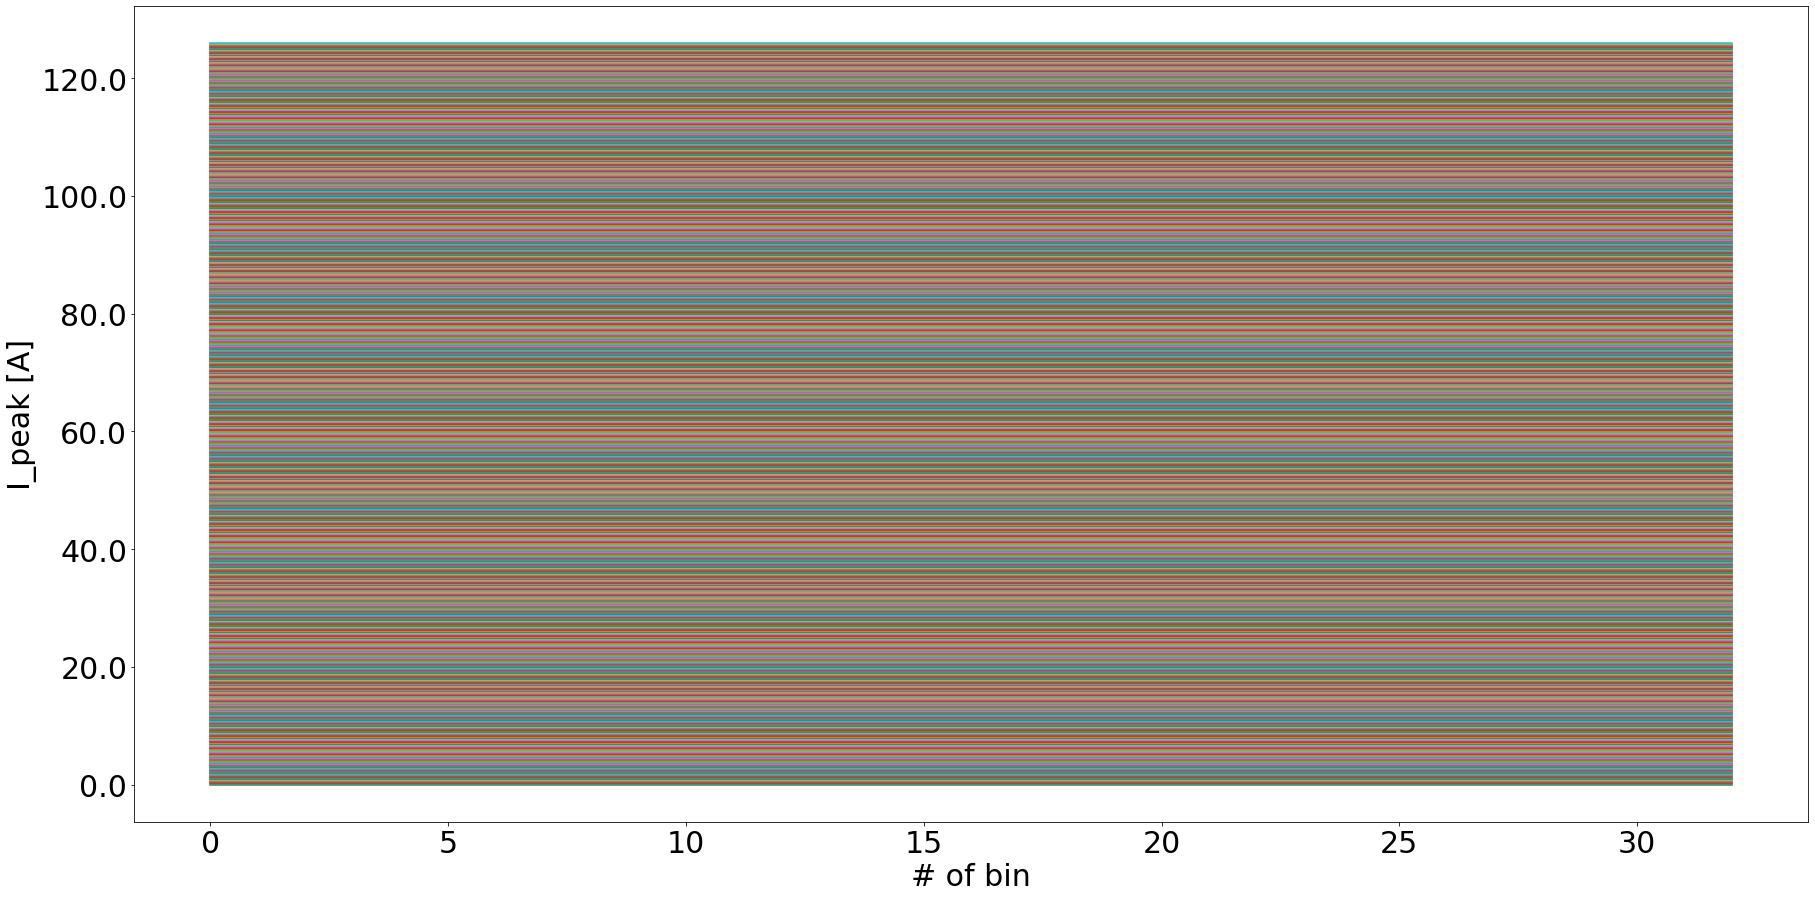

In [81]:
startTurn =int((n_fill+n_q_ramp)/step-1)
startRF = 0
nRFsamp = 1
fig1,axes1 = plt.subplots(1,1)

for i in range(int(nBunch/1)):
    startRF = i*fill_step*1
    rng1 = NpRF*(h[0]*startTurn+startRF)+int(NpRF/4)*0+0
    rng2 = NpRF*(h[0]*startTurn+startRF+nRFsamp)-int(NpRF/4)*0-0
    axes1.plot(Ibi[rng1:rng2:step1]+0.1*i,ms=10)

fig1.set_figheight(15)
fig1.set_figwidth(30)

axes1.set_xlabel('# of bin',fontsize=30)
axes1.set_ylabel('I_peak [A]',fontsize=30)
axes1.tick_params(labelsize=30)
y_labels = axes1.get_yticks()
axes1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))

fn_before = os.path.join(cwd,'before.jpg')
plt.savefig(fn_before,bbox_inches='tight')
plt.show()

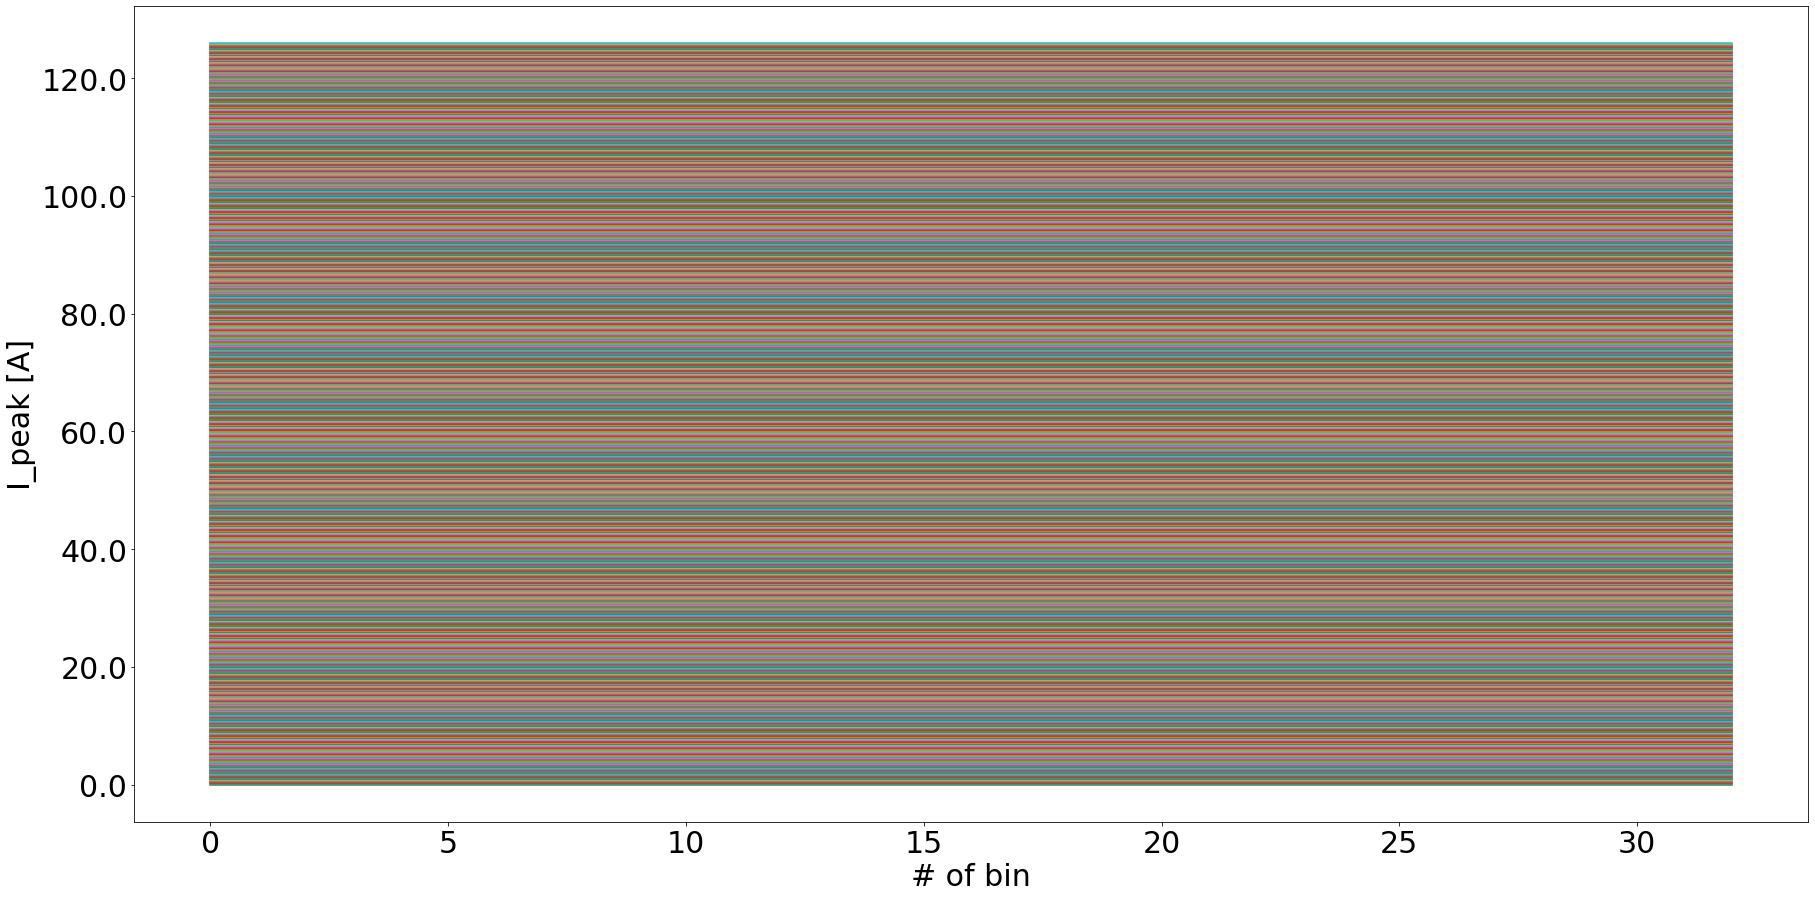

In [82]:
startTurn =int(nTurns/step-1)
startRF = 0
nRFsamp = 1
fig1,axes1 = plt.subplots(1,1)

for i in range(int(nBunch/1)):
    startRF = i*fill_step*1
    rng1 = NpRF*(h[0]*startTurn+startRF)+int(NpRF/4)*0+0
    rng2 = NpRF*(h[0]*startTurn+startRF+nRFsamp)-int(NpRF/4)*0-0
    axes1.plot(Ibi[rng1:rng2:step1]+0.1*i,ms=10)

fig1.set_figheight(15)
fig1.set_figwidth(30)
axes1.tick_params(labelsize=50)

axes1.set_xlabel('# of bin',fontsize=30)
axes1.set_ylabel('I_peak [A]',fontsize=30)
axes1.tick_params(labelsize=30)
y_labels = axes1.get_yticks()
axes1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))

fn_after = os.path.join(cwd,'after.jpg')
plt.savefig(fn_after,bbox_inches='tight')
plt.show()


In [85]:
# get info of all variables
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.5f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:20]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                          test: 3.55490 GiB
                          time: 380.67636 MiB
                           Ibi: 380.67636 MiB
                          Ibi2: 380.67636 MiB
                     emittance: 1.92270 MiB
                            dt: 1.92270 MiB
                         gamma: 1.92270 MiB
             bucket_lower_lim3: 1.92270 MiB
             bucket_upper_lim3: 1.92270 MiB
                       dt_mask: 1.92270 MiB
                    gamma_mask: 1.92270 MiB
                           t_0: 1.92270 MiB
                       gamma_0: 1.92270 MiB
                     nPar_mask: 1.92270 MiB
                         sig_t: 1.92270 MiB
                     sig_gamma: 1.92270 MiB
                   sig_t_gamma: 1.92270 MiB
                     gamma_fft: 265.71875 KiB
                   fileContent: 265.65723 KiB
                          mask: 246.18750 KiB


In [86]:
path = os.path.join(cwd,"{0:.2f}A".format(nBunch*NperBunch*f0*1.6e-19))
try:
    os.mkdir(path)
except OSError:
    print ("Creation of the directory %s failed" % path)
else:
    print ("Successfully created the directory %s" % path)
files = os.listdir(cwd)
jpgFn = [i for i in files if i[-3:]=='jpg']
for i in jpgFn:
    path_jpg = os.path.join(cwd,i)
    subprocess.call(["mv",path_jpg,path])

Successfully created the directory /home/txin/Dropbox/code/Cpp/APES_pack/APES8.2/eSR/2RF/bench_no_dynamic_2/0.00A
